# Fitbit Exploration
For an explanation on the variables, take a look at the [data dictionary created by Fitabase](https://www.fitabase.com/media/1546/fitabasedatadictionary.pdf). 

Link to help create a table of contents is [here](https://sebastianraschka.com/Articles/2014_ipython_internal_links.html).

In [21]:
import warnings
warnings.filterwarnings('ignore')

# Sleep Sensitivity
In this notebook we take a look at the variables that might be affecting sleep the most.

In [22]:
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.dates as mdates

# Table of Contents
1. [Data Import](#data_import)
    1. [Labels](#labels)
    2. [Features](#features)
        1. Complete
        2. IEQ
        3. Mood
        4. Self-Report Sleep
        5. Fitbit Activity
2. [Pre-Processing](#preprocessing)
    1. [Feature Engineering](#feature_engineering)
        1. [Mutual Information](#mutual_information)
        2. [Clustering](#clustering)
        3. [Principal Component Analysis](#pca)

In [23]:
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='data_import'></a>

# Data Import
We have a spate of data available to us from the three main modalities: beacon, Fitbit, and Beiwe. Each of these datasets can be analyzed individually or all together. Each of these datasets has already been created via the `build_features` source code.

<a id='labels'></a>

## Labels
We can start by importing the labels dataset: Fitbit sleep metrics.

In [24]:
labels = pd.read_csv("../data/processed/fitbit-sleep_summary-ux_s20.csv",parse_dates=["start_time","end_time"])
labels.describe()

,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,efficiency,redcap,beacon,nrem_count,rem2nrem_count,nrem_minutes,rem2nrem_minutes,tst_fb
count,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,2950.000000,1724.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000
mean,3.732711,77.101962,28.256031,243.267289,9.386619,86.384690,30.306208,63.342232,91.695722,40.865763,21.473898,31.988742,0.307744,320.369251,0.274370,7.834936
std,1.468774,25.795931,8.626905,55.887225,4.294173,30.717377,9.232387,19.729932,8.480847,21.837114,11.936372,9.339972,0.148229,64.050766,0.095751,1.524611
min,0.000000,0.000000,4.000000,51.000000,0.000000,0.000000,5.000000,14.000000,27.000000,0.000000,1.000000,5.000000,0.000000,116.000000,0.000000,3.033333
25%,3.000000,60.000000,22.000000,208.000000,6.000000,66.000000,24.000000,50.000000,91.000000,23.000000,13.000000,26.000000,0.200000,284.000000,0.210526,7.000000
50%,4.000000,77.000000,28.000000,242.000000,9.000000,87.000000,30.000000,62.000000,93.000000,45.000000,21.000000,32.000000,0.285714,323.000000,0.272727,7.900000
75%,5.000000,94.000000,34.000000,278.000000,12.000000,107.000000,36.000000,75.000000,96.000000,56.000000,29.000000,38.000000,0.388889,360.000000,0.338542,8.783333
max,10.000000,177.000000,64.000000,598.000000,28.000000,219.000000,66.000000,174.000000,100.000000,87.000000,46.000000,68.000000,1.142857,775.000000,0.778409,17.683333


<a id='features'></a>

## Features
Next we can import the various datasets that can be used for the features. We start with the most complete dataset and trickle down from there.

### Complete Features Dataset
This dataset, while short, is the most comprehensive and includes overlapping data from all modalities.

In [25]:
features_complete = pd.read_csv("../data/processed/all_modalities-fb_and_gps_filtered-ux_s20.csv",parse_dates=["start_time","end_time"])
features_complete.describe()

,lat_mean,long_mean,altitude_mean,accuracy_mean,tvoc_mean,lux_mean,no2_mean,co_mean,co2_mean,pm1_number_mean,pm2p5_number_mean,pm10_number_mean,pm1_mass_mean,pm2p5_mass_mean,pm10_mass_mean,temperature_c_mean,rh_mean,beacon,fitbit,redcap,lat_median,long_median,altitude_median,accuracy_median,tvoc_median,lux_median,no2_median,co_median,co2_median,pm1_number_median,pm2p5_number_median,pm10_number_median,pm1_mass_median,pm2p5_mass_median,pm10_mass_median,temperature_c_median,rh_median,lat_delta,long_delta,altitude_delta,accuracy_delta,tvoc_delta,lux_delta,no2_delta,co_delta,co2_delta,pm1_number_delta,pm2p5_number_delta,pm10_number_delta,pm1_mass_delta,pm2p5_mass_delta,pm10_mass_delta,temperature_c_delta,rh_delta,lat_delta_percent,long_delta_percent,altitude_delta_percent,accuracy_delta_percent,tvoc_delta_percent,lux_delta_percent,no2_delta_percent,co_delta_percent,co2_delta_percent,pm1_number_delta_percent,pm2p5_number_delta_percent,pm10_number_delta_percent,pm1_mass_delta_percent,pm2p5_mass_delta_percent,pm10_mass_delta_percent,temperature_c_delta_percent,rh_delta_percent,content_morning,stress_morning,lonely_morning,sad_morning,energy_morning,tst,sol,naw,restful,content_evening,stress_evening,lonely_evening,sad_evening,energy_evening,calories,steps,distance,sedentary_minutes,lightly_active_minutes,fairly_active_minutes,very_active_minutes,calories_from_activities,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,efficiency,nrem_count,rem2nrem_count,nrem_minutes,rem2nrem_minutes,tst_fb
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,12.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,12.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,12.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,15.000000,12.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,22.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,31.708245,-97.281673,183.152029,226.326105,251.450812,2.584985,1.040589,2.675229,1005.861635,6.940623,7.297195,7.339740,0.529240,1.264329,2.180827,26.794703,42.677904,21.826087,28.521739,44.000000,31.708215,-97.281549,183.926963,46.372968,251.636715,2.134963,1.068903,2.598729,1002.601932,6.641631,7.035111,7.086057,0.513637,1.251939,2.169061,26.755616,42.614130,0.002767,0.005028,9.797499,2762.532037,145.283333,7.662299,0.216908,1.548383,231.177142,8.077241,8.590784,8.665080,0.561023,0.988647,1.018249,1.450725,3.604710,0.008496,-0.005184,6.285770,51440.372741,inf,inf,-53.704067,127.955648,29.344919,1091.017982,3660.212034,2481.321599,395.931490,117.457011,58.275877,5.728423,8.640482,2.347826,0.772727,0.130435,0.086957,2.391304,6.760870,13.173913,1.782609,2.130435,2.347826,0.521739,0.217391,0.086957,2.478261,2168.956522,7594.739130,3.272456,706.434783,187.826087,16.695652,25.391304,874.260870,3.826087,74.695652,28.043478,247.695652,8.434783,78.913043,29.521739,63.347826,93.173913,31.869565,0.277568,322.391304,0.244884,7.744203
std,1.406060,0.400138,17.965757,196.406064,86.479202,6.985300,0.146838,2.892325,305.096311,4.755816,4.742392,4.693987,0.302098,0.299442,0.230945,2.134758,5.469532,10.002964,12.090077,18.466185,1.406037,0.400200,17.193880,23.869096,88.165647,6.447158,0.208614,2.890972,311.805323,4.614899,4.677822,4.627979,0.297801,0.290936,0

### IEQ Features Dataset
Arguably the most restrictive dataset after the complete set, we can import the IEQ features from the beacon. We have to do a little pre-processing first to remove the GPS features and any column that ends with "percent" since these data are bad. 

In [26]:
ieq_data = pd.read_csv("../data/processed/beacon-fb_and_gps_filtered_summary-ux_s20.csv",parse_dates=["start_time","end_time"])
features_ieq = ieq_data.merge(right=labels,left_on=["start_time","end_time","beacon","redcap","beiwe"],right_on=["start_time","end_time","beacon","redcap","beiwe"])
features_ieq.drop([c for c in features_ieq.columns if c.endswith("percent")],axis="columns",inplace=True)
for gps_label in ["long","lat","accuracy","altitude"]:
    features_ieq.drop([c for c in features_ieq.columns if c.startswith(gps_label)],axis="columns",inplace=True)
features_ieq.dropna(subset=["tvoc_mean"],inplace=True)
features_ieq.describe()

,tvoc_mean,lux_mean,no2_mean,co_mean,co2_mean,pm1_number_mean,pm2p5_number_mean,pm10_number_mean,pm1_mass_mean,pm2p5_mass_mean,pm10_mass_mean,temperature_c_mean,rh_mean,beacon,fitbit,redcap,tvoc_median,lux_median,no2_median,co_median,co2_median,pm1_number_median,pm2p5_number_median,pm10_number_median,pm1_mass_median,pm2p5_mass_median,pm10_mass_median,temperature_c_median,rh_median,tvoc_delta,lux_delta,no2_delta,co_delta,co2_delta,pm1_number_delta,pm2p5_number_delta,pm10_number_delta,pm1_mass_delta,pm2p5_mass_delta,pm10_mass_delta,temperature_c_delta,rh_delta,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,efficiency,nrem_count,rem2nrem_count,nrem_minutes,rem2nrem_minutes,tst_fb
count,225.000000,223.000000,120.000000,225.000000,225.000000,212.000000,212.000000,212.000000,212.000000,212.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,223.000000,120.000000,225.000000,225.000000,212.000000,212.000000,212.000000,212.000000,212.000000,225.000000,225.000000,225.000000,225.000000,223.000000,120.000000,225.000000,225.000000,212.000000,212.000000,212.000000,212.000000,212.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,265.534761,3.208712,1.079495,2.616999,971.846893,8.507479,8.825611,8.851313,0.619491,1.346435,2.132007,26.935384,42.584385,23.471111,30.560000,43.320000,261.623444,2.578835,1.079890,2.587492,969.282670,8.073657,8.413720,8.438968,0.593751,1.321277,2.114580,26.937963,42.510136,167.211975,8.995521,0.122769,1.109693,195.532131,9.720924,10.125966,10.170523,0.648698,1.064177,1.003022,1.280185,3.294123,3.520000,72.488889,27.555556,248.195556,9.204444,83.444444,29.822222,62.297778,93.182222,31.075556,0.305811,320.684444,0.261680,7.773778
std,144.383798,6.818129,0.326953,2.618360,375.788692,9.678663,9.429568,9.290298,0.595378,0.558059,0.598780,1.906726,5.466517,10.712989,11.809772,16.769839,142.637621,6.747184,0.327470,2.601741,376.417964,9.102868,8.905938,8.795275,0.562893,0.538596,0.592442,1.918598,5.368009,163.335493,14.457288,0.206673,1.499931,161.752215,14.050166,13.385237,13.141243,0.867057,0.847131,0.812831,0.776140,2.286696,1.319767,27.715408,7.292228,52.426028,4.221858,31.248968,7.787607,17.811394,6.321565,7.929296,0.146321,58.409140,0.092479,1.441735
min,19.016547,0.000000,-0.276564,-0.031249,429.603078,0.116044,0.469432,0.598738,0.088306,0.654342,0.546604,23.000000,31.449031,1.000000,9.000000,10.000000,9.500000,0.000000,-0.276482,-0.038750,426.243622,0.116044,0.469432,0.598738,0.080327,0.654342,0.546604,23.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,88.000000,0.000000,0.000000,7.000000,22.000000,44.000000,11.000000,0.000000,127.000000,0.000000,3.066667
25%,193.786395,0.007152,0.949357,1.007305,732.848084,2.388951,2.718550,2.836187,0.244587,0.964852,1.927937,25.241865,39.153297,17.000000,16.000000,36.000000,188.458333,0.000000,0.962680,0.989350,731.971655,2.214961,2.465948,2.501066,0.230586,0.952692,1.913265,25.000000,39.375000,84.466667,0.000000,0.034163,0.320700,96.169015,3.495808,4.243369,4.397412,0.283621,0.673280,0.627820,1.000000,2.000000,3.000000,54.000000,23.000000,222.000000,6.000000,65.000000,25.000000,51.000000,92.000000,26.000000,0.192308,293.000000,0.210300,7.000000
50%,239.581167,0.511244,1.083818,2.211820,891.313773,6.536288,7.063853,7.145993,0.488058,1.239731,2.102732,27.167868,41.766030,21.000000,37.000000,42.000000,236.975000,0.000000,1.083311,2.109333,881.229664,6.298459,6.915787,6.960081,0.483708,1.179588,2.068532,27.000000,42.000000,131.366667,2.142000,0.046670,0.803500,165.642820,5.737971,6.388136,6.564257,0.417866,0.908427,0.901842,1.000000,2.925000,3.000000,75.000000,27.000000,252.000000,9.000000,87.000000,30.000000,60.000000,94.000000,30.000000,0.3000

### Self-Report Mood Features Dataset
A more complex relationship

In [27]:
features_mood = pd.read_csv("../data/processed/beiwe_fitbit-evening_mood_and_sleep-ux_s20.csv",parse_dates=["start_date","end_date","start_time","end_time"])
features_mood.describe()

,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,efficiency,redcap,beacon,nrem_count,rem2nrem_count,nrem_minutes,rem2nrem_minutes,tst_fb,content,stress,lonely,sad,energy
count,641.000000,641.000000,641.00000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,474.000000,641.000000,641.000000,641.000000,641.000000,641.000000,640.000000,639.000000,641.000000,638.000000,640.000000
mean,3.594384,74.964119,28.74883,247.928237,9.099844,87.430577,30.393136,64.536661,92.427457,40.783151,20.556962,32.343214,0.297643,322.892356,0.275132,7.914327,2.160938,0.816901,0.575663,0.415361,2.035938
std,1.442946,25.062926,9.04542,56.491076,4.300002,32.056814,9.371243,19.464687,7.952680,20.435908,10.027548,9.757088,0.151104,63.062340,0.096930,1.516717,0.824529,0.888429,0.827817,0.746451,1.080611
min,1.000000,6.000000,4.00000,51.000000,0.000000,0.000000,5.000000,14.000000,27.000000,0.000000,1.000000,5.000000,0.000000,117.000000,0.000000,3.333333,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,58.000000,23.00000,212.000000,6.000000,65.000000,25.000000,52.000000,91.000000,23.000000,13.000000,26.000000,0.186047,286.000000,0.214085,7.000000,2.000000,0.000000,0.000000,0.000000,1.000000
50%,4.000000,76.000000,28.00000,247.000000,9.000000,88.000000,30.000000,63.000000,94.000000,42.000000,21.000000,32.000000,0.272727,326.000000,0.276094,8.033333,2.000000,1.000000,0.000000,0.000000,2.000000
75%,4.000000,92.000000,34.00000,284.000000,12.000000,110.000000,36.000000,75.000000,96.000000,58.000000,27.250000,38.000000,0.384615,361.000000,0.338624,8.916667,3.000000,1.000000,1.000000,1.000000,3.000000
max,9.000000,148.000000,64.00000,426.000000,28.000000,209.000000,66.000000,136.000000,100.000000,86.000000,44.000000,68.000000,0.863636,540.000000,0.585153,14.650000,3.000000,3.000000,3.000000,3.000000,4.000000


### Self-Report Sleep Metric (SRSM) Features Dataset
The feature set that should have the greatest relationship with the Fitbit since it is another measure of sleep quality. 

In [28]:
features_srsm = pd.read_csv("../data/processed/beiwe_fitbit-sleep_summary-ux_s20.csv",parse_dates=["date","start_date","end_date","start_time","end_time"])
features_srsm.describe()

,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,efficiency,redcap,beacon,nrem_count,rem2nrem_count,nrem_minutes,rem2nrem_minutes,tst_fb,tst_ema,sol_ema,naw_ema,restful_ema
count,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,674.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000
mean,3.650433,75.497835,28.380952,246.637446,9.267316,85.244589,30.301948,62.399351,92.117965,40.139610,20.841246,32.031385,0.301672,322.135281,0.267790,7.829654,6.947348,18.343615,1.724026,1.998918
std,1.395741,25.259327,8.332077,55.482612,4.473465,31.033842,8.969236,18.831281,8.151208,20.156081,11.235558,8.959164,0.151561,61.843388,0.091595,1.488608,1.296218,20.954166,1.653856,0.794755
min,0.000000,0.000000,7.000000,87.000000,0.000000,0.000000,5.000000,16.000000,27.000000,0.000000,1.000000,9.000000,0.000000,126.000000,0.000000,3.033333,0.000000,0.000000,0.000000,0.000000
25%,3.000000,60.000000,23.000000,210.000000,6.000000,64.000000,25.000000,50.000000,91.000000,28.500000,13.000000,26.000000,0.187500,285.000000,0.208391,6.950000,6.000000,6.750000,1.000000,2.000000
50%,4.000000,76.000000,28.000000,243.500000,9.000000,85.500000,30.000000,61.000000,94.000000,42.000000,21.000000,32.000000,0.275431,324.000000,0.268551,7.866667,7.000000,15.000000,2.000000,2.000000
75%,5.000000,91.000000,34.000000,281.250000,12.000000,106.000000,36.000000,73.000000,96.000000,58.000000,29.000000,38.000000,0.382353,361.000000,0.335464,8.766667,8.000000,20.000000,2.000000,3.000000
max,9.000000,148.000000,61.000000,458.000000,24.000000,209.000000,63.000000,145.000000,100.000000,85.000000,44.000000,66.000000,1.125000,540.000000,0.590000,14.650000,12.000000,240.000000,15.000000,3.000000


### Fitbit Activity Features Dataset
The largest and final features set is the activity data from Fitbit which should be the closest match to all Fitbit sleep data we have since both are collected from the same source.

In [29]:
features_activity = pd.read_csv("../data/processed/fitbit_fitbit-daily_activity_and_sleep-ux_s20.csv",parse_dates=["date","start_date","end_date","start_time","end_time"])
features_activity.describe()

,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,efficiency,redcap,beacon,nrem_count,rem2nrem_count,nrem_minutes,rem2nrem_minutes,tst_fb,calories,bmr,steps,distance,sedentary_minutes,lightly_active_minutes,fairly_active_minutes,very_active_minutes,calories_from_activities,bmi,fat,weight,food_calories_logged,water_logged
count,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,2843.000000,1654.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000
mean,3.734177,77.019987,28.243171,242.986009,9.387075,86.241839,30.301799,63.497335,91.736842,40.992613,21.375453,31.977348,0.307748,320.005996,0.274237,7.829086,2170.781479,1429.503997,7445.032978,3.262410,744.418388,206.360426,16.420386,20.581945,902.806462,22.289431,1.664820,134.761209,105.276149,1.852765
std,1.469888,25.776219,8.597763,55.765305,4.307345,30.854521,9.217585,19.717114,8.375837,21.792209,11.847433,9.312389,0.148590,63.956682,0.096230,1.525016,523.857979,202.346895,5340.182326,2.471111,192.580767,98.976801,25.485015,30.894012,514.843061,2.943300,6.031096,22.517273,441.928007,10.833245
min,0.000000,0.000000,4.000000,51.000000,0.000000,0.000000,5.000000,14.000000,27.000000,0.000000,1.000000,5.000000,0.000000,116.000000,0.000000,3.033333,1049.000000,1046.000000,4.000000,0.001616,0.000000,0.000000,0.000000,0.000000,0.000000,18.037397,0.000000,96.990000,0.000000,0.000000
25%,3.000000,60.000000,22.000000,208.000000,6.000000,66.000000,24.000000,50.000000,91.000000,23.000000,13.000000,26.000000,0.200000,284.000000,0.210526,7.000000,1807.250000,1255.000000,3482.250000,1.451195,633.000000,141.000000,0.000000,0.000000,533.000000,20.312498,0.000000,118.000000,0.000000,0.000000
50%,4.000000,77.000000,28.000000,242.000000,9.000000,86.000000,30.000000,62.000000,93.000000,45.000000,21.000000,32.000000,0.285714,322.000000,0.272270,7.883333,2097.000000,1365.000000,6226.500000,2.658468,729.000000,194.000000,7.000000,5.000000,818.500000,21.659504,0.000000,130.000000,0.000000,0.000000
75%,5.000000,94.000000,34.000000,278.000000,12.000000,106.000000,36.000000,75.000000,96.000000,58.000000,29.000000,38.000000,0.388889,359.000000,0.338101,8.783333,2448.000000,1551.000000,10177.250000,4.504787,820.000000,257.000000,21.000000,33.000000,1171.750000,24.274609,0.000000,140.000000,0.000000,0.000000
max,10.000000,177.000000,61.000000,598.000000,28.000000,219.000000,64.000000,174.000000,100.000000,87.000000,46.000000,66.000000,1.142857,775.000000,0.778409,17.683333,5437.000000,1910.000000,37485.000000,17.323717,1440.000000,636.000000,198.000000,275.000000,4242.000000,31.822655,25.224001,193.600000,3054.000000,120.000000


<a id='pre-processing'></a>

# Pre-Processing
The analysis section is outlined as followed:

- [Target Data](#target_data)
- [Feature Data](#feature_data)
- [Feature Engineering](#feature_engineering)

Much of this code has been refractured into the `processing` source code and we import that module below so that we can simplify the code presented in this notebook.

In [30]:
from src.processing import process
# defining feature engineering object
pp = process.preprocess()

<a id='target_data'></a>

## Target Data
Since the feature sets are all corroborated against the Fitbit sleep data, there won't be any missing data values so we don't have to worry about filling in any gaps.

The general outline is as follows:

- [Summary](#summary)
- [Scaling and Normalizing](#scaling)
- [Clustering](#clustering)

<a id='summary'></a>

### Summary
Here we look at summarizing data and figures to get a sense of the target data we are considering. We will start by removing some columns that are not necessary for analysis.

In [31]:
targets = labels.drop(['start_date','end_date','start_time','end_time','beiwe','end_time','redcap','beacon'],axis="columns",errors="ignore")
targets.describe()

,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,efficiency,nrem_count,rem2nrem_count,nrem_minutes,rem2nrem_minutes,tst_fb
count,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000
mean,3.732711,77.101962,28.256031,243.267289,9.386619,86.384690,30.306208,63.342232,91.695722,31.988742,0.307744,320.369251,0.274370,7.834936
std,1.468774,25.795931,8.626905,55.887225,4.294173,30.717377,9.232387,19.729932,8.480847,9.339972,0.148229,64.050766,0.095751,1.524611
min,0.000000,0.000000,4.000000,51.000000,0.000000,0.000000,5.000000,14.000000,27.000000,5.000000,0.000000,116.000000,0.000000,3.033333
25%,3.000000,60.000000,22.000000,208.000000,6.000000,66.000000,24.000000,50.000000,91.000000,26.000000,0.200000,284.000000,0.210526,7.000000
50%,4.000000,77.000000,28.000000,242.000000,9.000000,87.000000,30.000000,62.000000,93.000000,32.000000,0.285714,323.000000,0.272727,7.900000
75%,5.000000,94.000000,34.000000,278.000000,12.000000,107.000000,36.000000,75.000000,96.000000,38.000000,0.388889,360.000000,0.338542,8.783333
max,10.000000,177.000000,64.000000,598.000000,28.000000,219.000000,66.000000,174.000000,100.000000,68.000000,1.142857,775.000000,0.778409,17.683333


<a id='feature_engineering'></a>

#### Distributions

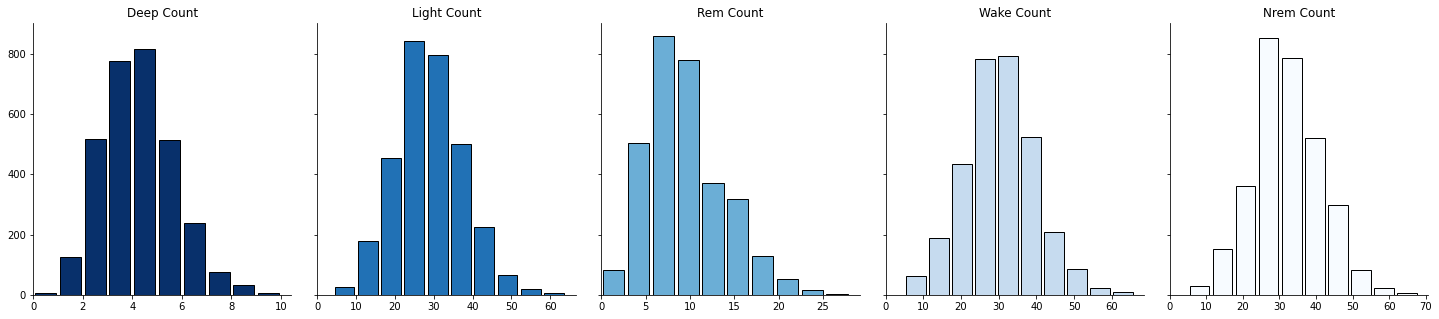

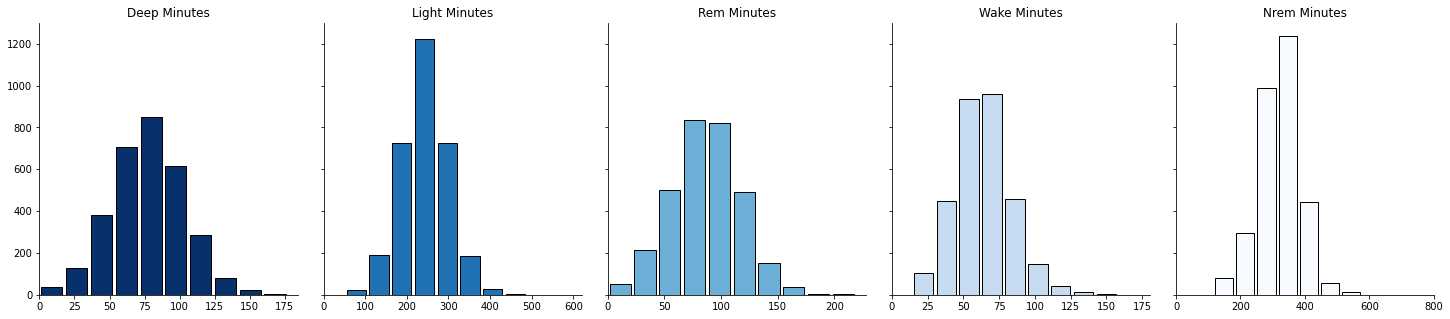

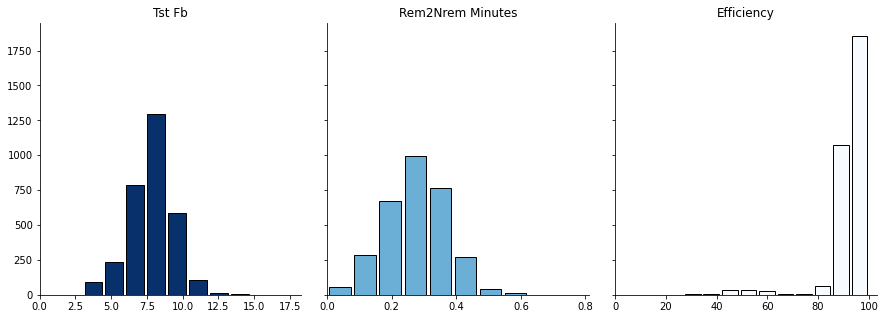

In [32]:
# Count metrics
sm_count = targets[[column for column in targets.columns if column.endswith("count") and "2" not in column]]
pp.plot_hist(sm_count)
# Minute metrics
sm_minutes = targets[[column for column in targets.columns if column.endswith("minutes") and "2" not in column]]
pp.plot_hist(sm_minutes)
# Other metrics
sm = targets[["tst_fb","rem2nrem_minutes","efficiency"]]
pp.plot_hist(sm)

<div class="alert alert-block alert-info">
    
Remarkably all but one of the sleep metric targets are normally distributed. The only metric that is not is `efficiency` which is _heavily_ skewed towards higher values, but we can try normalizing the efficiency values to use as a target instead.
    
</div>

<a id="scaling"></a>

### Scaling and Normalizing
There are a few datasets that could use some scaling, primarily those datasets that show `minutes` and the `efficiency` target. Below we can try a few methods to deal with these data.

#### Scaling
Data recorded as minutes spent in different stages should be scaled based on the TST for that night since time spent in sleep stages is dependent on the time one is asleep. However this is not scaling in a traditional sense, but more of a _target engineering_.

In [33]:
for column in targets.columns:
    if column.endswith("minutes"):
        variable = column.split("_")[0]
        if variable not in ["rem2nrem"]:
            targets[variable+"_percent"] = targets[column] / (targets["tst_fb"]*60) * 100
            targets.drop(column,axis="columns",inplace=True)
        
targets["rem2nrem_percent"] = targets["rem_percent"] / targets["nrem_percent"]
targets.head()

,deep_count,light_count,rem_count,wake_count,efficiency,nrem_count,rem2nrem_count,rem2nrem_minutes,tst_fb,deep_percent,light_percent,rem_percent,wake_percent,nrem_percent,rem2nrem_percent
0,5,20,10,21,97,25,0.400000,0.276094,6.766667,20.689655,52.463054,20.197044,6.650246,73.152709,0.276094
1,4,31,6,33,87,35,0.171429,0.136232,8.216667,19.269777,50.709939,9.533469,20.486815,69.979716,0.136232
2,2,17,8,20,95,19,0.421053,0.210970,5.483333,14.285714,57.750760,15.197568,12.765957,72.036474,0.210970
3,5,21,11,25,96,26,0.423077,0.259375,7.450000,17.449664,54.138702,18.568233,9.843400,71.588367,0.259375
4,5,20,14,28,92,25,0.560000,0.334601,6.933333,23.076923,40.144231,21.153846,15.625000,63.221154,0.334601


Now we can check the distributions again

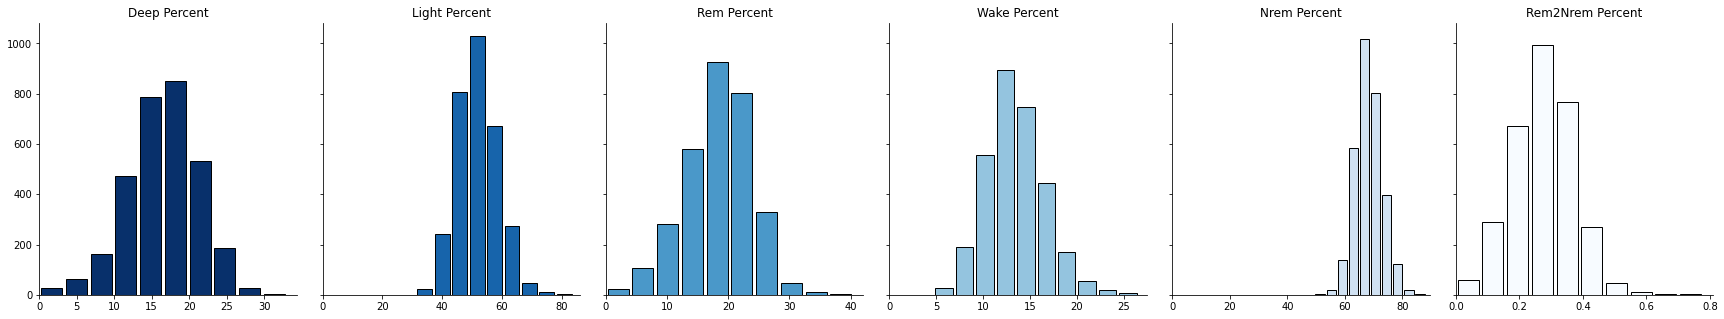

In [34]:
# Percent metrics
sm_percent = targets[[column for column in targets.columns if column.endswith("percent")]]
pp.plot_hist(sm_percent)

<div class="alert alert-block alert-info">
    
Targets are still normally distributed but now with some noteable outliers.
    
</div>

In [35]:
datasets = [features_ieq, features_mood, features_srsm, features_activity]
for dataset in datasets:
    for column in dataset.columns:
        if column.endswith("minutes"):
            variable = column.split("_")[0]
            if variable not in ["rem2nrem"]:
                dataset[variable+"_percent"] = dataset[column] / (dataset["tst_fb"]*60) * 100
                dataset.drop(column,axis="columns",inplace=True)

    dataset["rem2nrem_percent"] = dataset["rem_percent"] / dataset["nrem_percent"]

#### Normalizing
There is little to no need to normalize the sleep metrics other than `efficiency`, but the code is generalized in case we want to go back.

##### Target: Efficiency

The `process` module has a function to normalize the data:

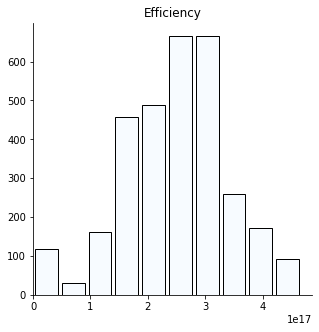

In [36]:
normalized_efficiency_only = pp.normalize(targets[["efficiency"]])
pp.plot_hist(normalized_efficiency_only)

The normalization has _dramatically_ increased the values of our data which might not make it an appropriate application. The cell below creates a new column in each of the feature sets with this normalized efficiency.

In [37]:
datasets = [features_ieq, features_mood, features_srsm, features_activity, labels]
for dataset in datasets:
    dataset["efficiency_normalized"] = pp.normalize(dataset[["efficiency"]]) # adding normalized efficiency to feature sets

<a id="clustering"></a>

### Clustering
Clustering might be the most appropriate technique to separate the `efficiency` target. Additionally, there might be a need to cluster the sleep times since we do seem to have a few outliers. 

In [38]:
from sklearn.cluster import KMeans

##### Target: Efficiency

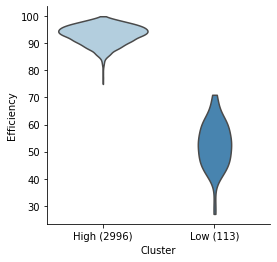

In [39]:
kmeans = KMeans(n_clusters=2, n_init=3, random_state=0)
targets["efficiency_cluster"] = kmeans.fit_predict(np.array(dataset["efficiency"]).reshape(-1, 1))
fig, ax = plt.subplots(figsize=(4,4))
n_high = len(targets[targets["efficiency_cluster"] == 0])
n_low = len(targets[targets["efficiency_cluster"] == 1])
sns.violinplot(x="efficiency_cluster",y="efficiency",palette="Blues",inner=None,cut=0,data=targets,ax=ax)
ax.set_xticklabels([f"High ({n_high})",f"Low ({n_low})"])
for loc in ["right","top"]:
    ax.spines[loc].set_visible(False)
ax.set_xlabel(ax.xaxis.get_label().get_text().split("_")[-1].title())
ax.set_ylabel(ax.yaxis.get_label().get_text().replace("_"," ").title())
plt.show()
plt.close()

We successfully split the efficiency values into an upper and lower score profile. The cell below adds the efficiency cluster to the data under the column `efficiency_low` where 0 indicates False and 1 is True. 

In [40]:
datasets = [features_ieq, features_mood, features_srsm, features_activity, labels]
for dataset in datasets:
    kmeans = KMeans(n_clusters=2, n_init=10, random_state=0)
    dataset["efficiency_low"] = kmeans.fit_predict(np.array(dataset["efficiency"]).reshape(-1, 1))

##### Target: TST from Fitbit
It would be interesting to see if we can capture irregularly high or low sleep times by clustering.

2 Clusters:
	Cluster 1
		Min:	3.033333333333333
		Max:	7.7333333333333325
		n:	1420
	Cluster 0
		Min:	7.75
		Max:	17.683333333333334
		n:	1689
3 Clusters:
	Cluster 2
		Min:	6.633333333333334
		Max:	8.616666666666667
		n:	1642
	Cluster 1
		Min:	3.033333333333333
		Max:	6.616666666666666
		n:	567
	Cluster 0
		Min:	8.633333333333333
		Max:	17.683333333333334
		n:	900


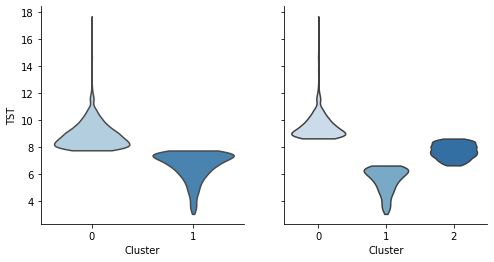

In [41]:
clusters = [2,3]
fig, axes = plt.subplots(1,len(clusters),figsize=(4*len(clusters),4),sharey=True)
for cluster, ax in zip(clusters, axes.flat):
    kmeans = KMeans(n_clusters=cluster, n_init=3, random_state=0)
    targets["tst_cluster"] = kmeans.fit_predict(np.array(dataset["tst_fb"]).reshape(-1, 1))
    sns.violinplot(x="tst_cluster",y="tst_fb",palette="Blues",inner=None,cut=0,data=targets,ax=ax)
    for loc in ["right","top"]:
        ax.spines[loc].set_visible(False)
    ax.set_xlabel(ax.xaxis.get_label().get_text().split("_")[-1].title())
    ax.set_ylabel("")
    print(f"{cluster} Clusters:")
    for tst_cluster in targets["tst_cluster"].unique():
        temp = targets[targets["tst_cluster"] == tst_cluster]
        print(f"\tCluster {tst_cluster}\n\t\tMin:\t{min(temp['tst_fb'])}\n\t\tMax:\t{max(temp['tst_fb'])}\n\t\tn:\t{len(temp)}")
    
axes[0].set_ylabel("TST")
    
plt.show()
plt.close()

The clustering seemed to work best when using 3 clusters. These clusters are **not** added to the feature sets but can be used for future analysis.

<a id="feature_data"></a>

## Feature Data Cleaning and Visualization
We can look at a few of the feature sets and clean up the data.

### Features: IEQ
The IEQ feature set has a considerable amount of missing values due to reading/connection issues with many of the sensors.

#### Dropping "Duplicate" Columns
There might be some columns that are providing duplicate information i.e. they have a strong correlation with each other. In the IEQ feature set, there are potentially two situations where we might have unecessary columns:
1. **Particulate Matter**: The SPS30 measures PM by size and by concentration (number and mass), but there are going to be strong correlations between the sizes as well as the concentration types.
2. **Summarizing Statistics**: In an attempt to provide the most overarching explanation of the data, all types of summarizing stats (mean, median, std) were provided, but perhaps there is considerable overlap between the statistics. 

Correlation matrixes can help us see the relationship of these features to one another which the following function generates.

In [42]:
def plot_correlation_matrix(df,annotate=True):
    """
    Plots correlation matrix between all variables in the df
    
    Inputs:
    - df: dataframe with columns named for the varaiables
    
    """
    corr = df.corr()
    corr = round(corr,2)
    #mask = np.triu(np.ones_like(corr, dtype=bool))
    fig, ax = plt.subplots(figsize=(9, 7))
    sns.heatmap(corr,
                     vmin=-1, vmax=1, center=0, 
                     cmap=sns.diverging_palette(20, 220, n=200),cbar_kws={'ticks':[-1,-0.5,0,0.5,1]},
                     square=True,linewidths=0.5,linecolor="black",annot=annotate,ax=ax)

    yticklabels = ax.get_yticklabels()
    yticklabels[0] = ' '
    ax.set_yticklabels(yticklabels,rotation=0,ha='right')

    xticklabels = ax.get_xticklabels()
    xticklabels[-1] = ' '
    ax.set_xticklabels(xticklabels,rotation=-45,ha='left')
        
    plt.show()
    plt.close()

##### Particulate Matter
Questions to answer:
- Do we need to include all size ranges?
- Do we need to include mass and number concentrations?

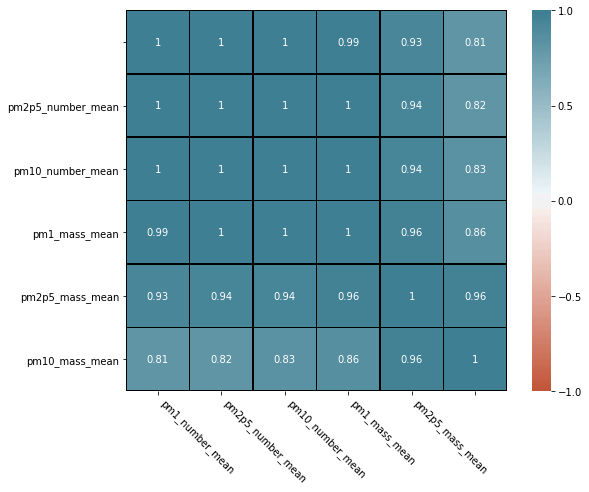

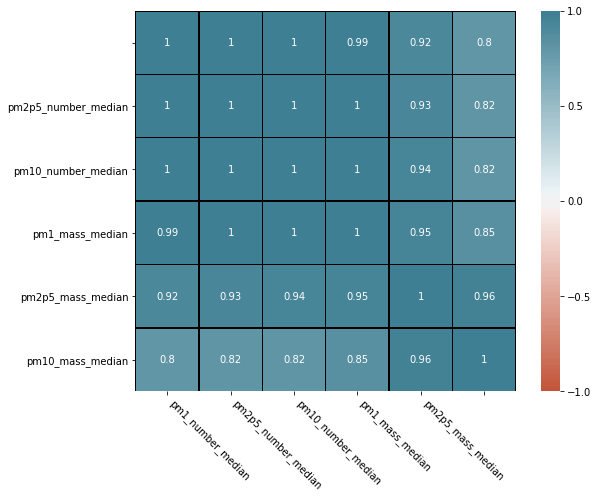

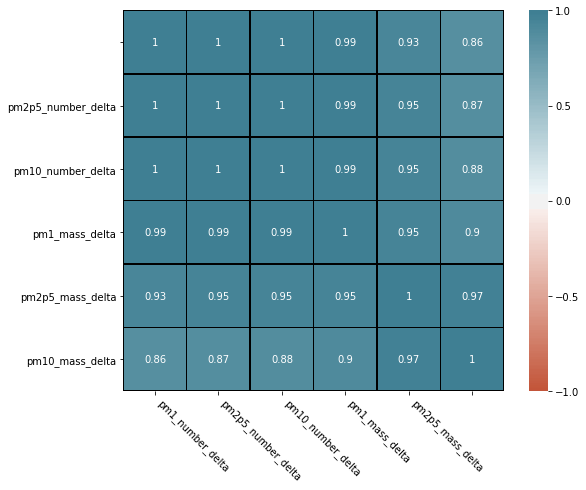

In [43]:
# PM Size Ranges
for metric in ["mean","median","delta"]:
    pp.plot_correlation_matrix(features_ieq[[column for column in features_ieq.columns if column.startswith("pm") and column.endswith(metric)]])

<div class="alert alert-block alert-success">
    
PM2.5 number and mass concentrations can be used as a decent enough proxy for PM1 and PM10 number and mass concentrations as all correlations are 0.95 and above.
    
</div>

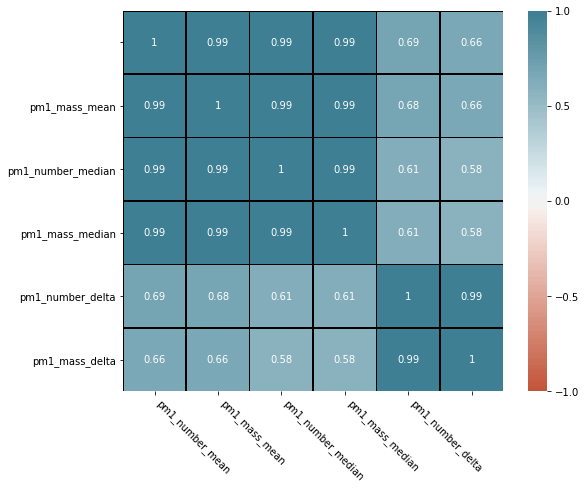

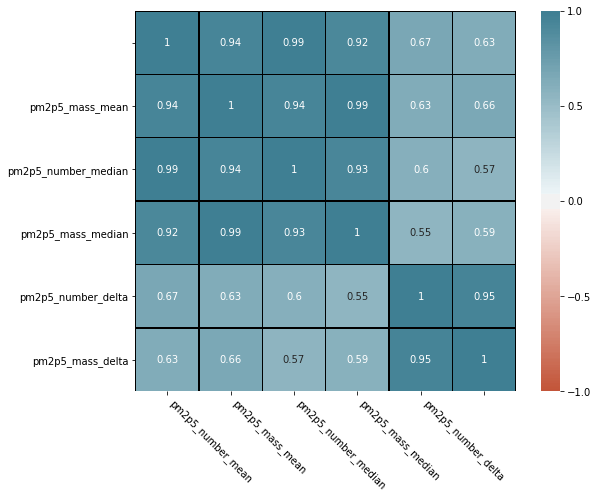

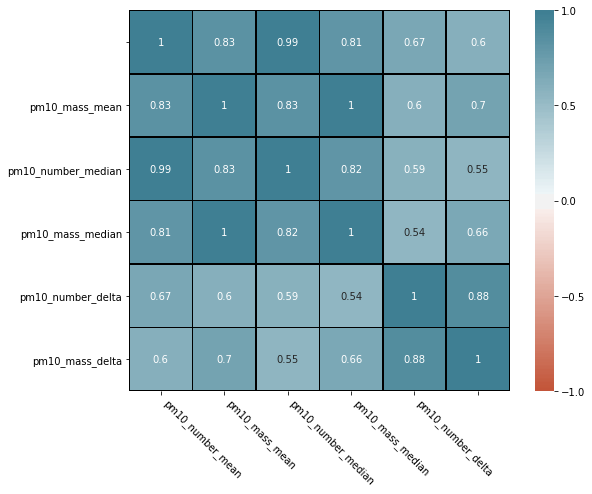

In [44]:
# PM mass and number
for size in ["1_","2p5","10"]:
    pp.plot_correlation_matrix(features_ieq[[column for column in features_ieq.columns if column.startswith("pm"+size)]])

<div class="alert alert-block alert-danger">
    
Mass and Number concentrations should be kept separate since their relationships are not as strong.
    
</div>

##### Summarizing Statistics
One real question:
- Are there significant differences between mean and median?

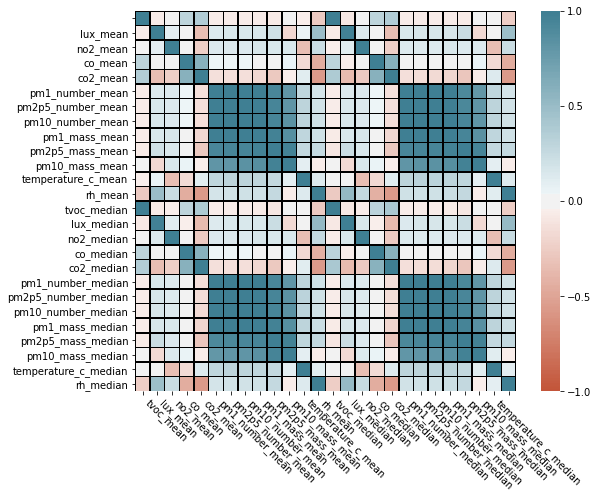

In [45]:
# PM only
pp.plot_correlation_matrix(features_ieq[[column for column in features_ieq.columns if (column.endswith("median") or column.endswith("mean"))]],annotate=False)

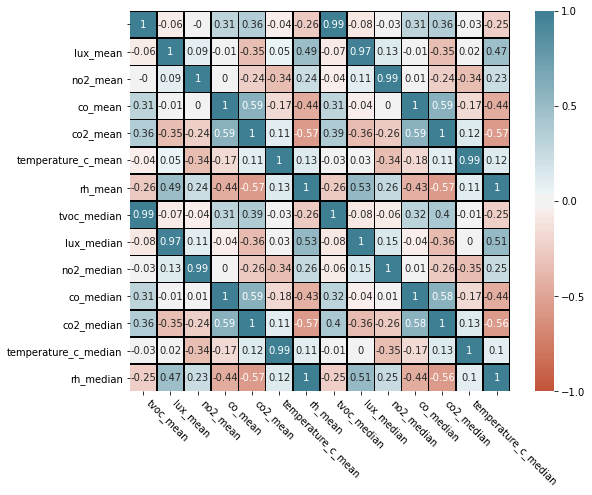

In [46]:
# Not PM
pp.plot_correlation_matrix(features_ieq[[column for column in features_ieq.columns if not column.startswith("pm") and (column.endswith("median") or column.endswith("mean"))]],annotate=True)

<div class="alert alert-block alert-success">
    
We will remove the mean concentration values and instead consider the median values only.
    
</div>

Based on the above analysis we will drop:
1. columns that begin with `pm1` or `pm10` (really just the former since it captures the latter)
2. columns that end with `mean`

In [47]:
features_ieq.drop([column for column in features_ieq.columns if column.startswith("pm1") or column.endswith("mean")],axis="columns",errors="ignore",inplace=True)
features_ieq.head()

,start_time,end_time,beacon,beiwe,fitbit,redcap,tvoc_median,lux_median,no2_median,co_median,co2_median,pm2p5_number_median,pm2p5_mass_median,temperature_c_median,rh_median,tvoc_delta,lux_delta,no2_delta,co_delta,co2_delta,pm2p5_number_delta,pm2p5_mass_delta,temperature_c_delta,rh_delta,start_date,end_date,deep_count,light_count,rem_count,wake_count,efficiency,nrem_count,rem2nrem_count,rem2nrem_minutes,tst_fb,deep_percent,light_percent,rem_percent,wake_percent,nrem_percent,rem2nrem_percent,efficiency_normalized,efficiency_low
0,2020-08-10 04:42:30,2020-08-10 12:35:30,21,lkkjddam,25,12,126.658333,2.040,NaN,10.359917,1600.754959,0.914249,0.895571,23.337500,33.0,91.90,0.136,NaN,0.731650,304.035761,1.960803,0.620298,1.000,0.950,2020-08-10,2020-08-10,2,26,2,25,91,28,0.071429,0.217791,7.883333,8.668076,60.253700,15.010571,16.067653,68.921776,0.217791,1.092353e+20,0
1,2020-08-11 03:35:00,2020-08-11 12:36:30,21,lkkjddam,25,12,233.566667,2.040,NaN,6.429275,1628.474180,1.287357,0.847762,25.000000,34.0,160.45,0.204,NaN,5.565250,202.651343,6.086460,0.665257,1.650,2.000,2020-08-11,2020-08-11,4,40,5,35,96,44,0.113636,0.256906,9.016667,11.460259,55.452865,17.190388,15.896488,66.913124,0.256906,1.941806e+20,0
2,2020-08-12 02:59:30,2020-08-12 10:52:30,21,lkkjddam,25,12,252.016667,2.040,NaN,10.271850,1596.122408,2.879650,0.939256,24.000000,33.0,108.60,0.204,NaN,0.512533,146.009840,5.472740,0.702017,0.000,1.500,2020-08-12,2020-08-12,3,34,7,35,93,37,0.189189,0.189504,7.883333,10.993658,61.522199,13.742072,13.742072,72.515856,0.189504,1.380096e+20,0
3,2020-08-14 03:05:00,2020-08-14 11:23:30,21,lkkjddam,25,12,223.700000,1.938,NaN,7.232700,1301.449844,1.232406,0.886675,25.000000,33.0,81.80,2.040,NaN,5.108383,233.372161,3.742991,0.736714,1.175,1.250,2020-08-14,2020-08-14,4,38,6,38,90,42,0.142857,0.218391,8.300000,9.839357,60.040161,15.261044,14.859438,69.879518,0.218391,9.699512e+19,0
4,2020-08-15 06:51:30,2020-08-15 11:30:00,21,lkkjddam,25,12,209.600000,2.040,NaN,10.886100,1274.110350,2.017288,1.046326,23.333333,34.0,149.30,0.136,NaN,0.684917,125.544723,43.415611,2.880943,1.000,2.575,2020-08-15,2020-08-15,2,18,4,16,97,20,0.200000,0.320000,4.633333,12.949640,50.000000,20.143885,16.906475,62.949640,0.320000,2.170750e+20,0


#### Missing Data
The IEQ feature set has _a lot_ of missing data (relative to its size) becuase of sensor issues or the sensor simply not being installed on the beacon (looking at you NO$_2$).

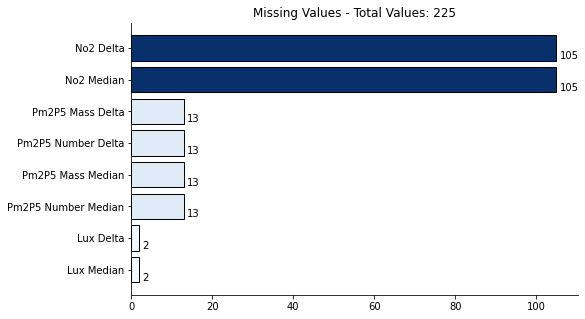

In [48]:
pp.plot_missing_data(features_ieq)

##### NO$_2$
The missing NO$_2$ values are from those beacons without the sensors, but the PM and Lux missing values deserve a little exploration.

##### PM
We need to check to see if the missing PM data is from one participant or more.

In [49]:
missing_pm = features_ieq[features_ieq["pm2p5_mass_median"].isnull()]
missing_pm.describe()

,beacon,fitbit,redcap,tvoc_median,lux_median,no2_median,co_median,co2_median,pm2p5_number_median,pm2p5_mass_median,temperature_c_median,rh_median,tvoc_delta,lux_delta,no2_delta,co_delta,co2_delta,pm2p5_number_delta,pm2p5_mass_delta,temperature_c_delta,rh_delta,deep_count,light_count,rem_count,wake_count,efficiency,nrem_count,rem2nrem_count,rem2nrem_minutes,tst_fb,deep_percent,light_percent,rem_percent,wake_percent,nrem_percent,rem2nrem_percent,efficiency_normalized,efficiency_low
count,13.0,13.0,13.0,13.000000,13.000000,0.0,13.000000,13.000000,0.0,0.0,13.000000,13.000000,13.000000,13.000000,0.0,13.000000,13.000000,0.0,0.0,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,1.300000e+01,13.0
mean,44.0,38.0,37.0,191.000855,16.041087,NaN,1.223540,488.533717,NaN,NaN,27.223077,50.766667,114.009402,29.509550,NaN,0.728680,58.570843,NaN,NaN,0.717949,5.594872,3.538462,26.230769,7.153846,28.384615,92.538462,29.769231,0.239371,0.205506,6.657692,18.733110,52.369012,14.234327,14.663551,71.102122,0.205506,1.445224e+20,0.0
std,0.0,0.0,0.0,58.980107,7.902952,NaN,0.107854,25.149345,NaN,NaN,0.424566,2.598637,53.903371,12.984831,NaN,0.276969,39.493033,NaN,NaN,0.606235,3.559367,1.050031,9.220935,3.693376,11.064496,4.647856,9.679479,0.115790,0.107199,2.031188,3.426511,5.388737,6.850852,3.823402,4.349460,0.107199,5.757117e+19,0.0
min,44.0,38.0,37.0,50.283333,4.388550,NaN,1.041625,426.243622,NaN,NaN,27.000000,45.000000,33.861111,8.544993,NaN,0.320700,11.403342,NaN,NaN,0.000000,0.250000,2.000000,11.000000,1.000000,11.000000,82.000000,14.000000,0.052632,0.031414,3.066667,11.088296,43.853211,2.500000,9.130435,63.853211,0.031414,3.563933e+19,0.0
25%,44.0,38.0,37.0,173.094444,13.107000,NaN,1.153833,481.671626,NaN,NaN,27.000000,50.000000,74.800000,22.603200,NaN,0.487950,25.691136,NaN,NaN,0.000000,1.333333,3.000000,22.000000,5.000000,24.000000,92.000000,25.000000,0.145833,0.120805,4.833333,16.304348,49.369748,8.256881,11.818182,68.354430,0.120805,1.228605e+20,0.0
50%,44.0,38.0,37.0,201.175000,16.788180,NaN,1.266767,489.648112,NaN,NaN,27.000000,51.500000,102.127778,33.586560,NaN,0.748200,57.269046,NaN,NaN,1.000000,7.000000,3.000000,27.000000,7.000000,30.000000,93.000000,30.000000,0.275862,0.204724,7.666667,19.402985,52.320675,14.130435,15.756303,69.979716,0.204724,1.380096e+20,0.0
75%,44.0,38.0,37.0,241.800000,19.635680,NaN,1.280217,502.240756,NaN,NaN,27.000000,52.000000,138.533333,38.723960,NaN,0.933517,96.181221,NaN,NaN,1.000000,8.000000,4.000000,32.000000,10.000000,37.000000,96.000000,36.000000,0.354839,0.290123,8.066667,21.195652,55.371901,20.042194,16.632444,74.827586,0.290123,1.941806e+20,0.0
max,44.0,38.0,37.0,254.500000,28.888440,NaN,1.395225,534.365603,NaN,NaN,28.000000,55.083333,218.550000,46.079520,NaN,1.246750,118.986524,NaN,NaN,2.000000,9.833333,6.000000,44.000000,13.000000,47.000000,97.000000,48.000000,0.371429,0.396552,9.083333,22.899160,64.476386,25.321101,23.394495,79.583333,0.396552,2.170750e+20,0.0


Looks like the missing PM data comes from only one participant but the remaining data looks fine (except for the NO2 data, of course). 

We should check to see if these 13 nights are an isolated incident or the PM sensor on the device was never working.

In [50]:
print("Number of nights of data:", len(features_ieq[features_ieq["beacon"] == 44]))
print("Number of nights with PM data:", len(features_ieq[(features_ieq["beacon"] == 44) & (features_ieq["pm2p5_mass_median"] > 0)]))

Number of nights of data: 24
Number of nights with PM data: 11


##### Light
The light values are not as important so we can simply fill the light levels in with an assumed value. Since we are looking at IEQ measurements during the evening, the light level should be approximately 0.

In [51]:
for column in features_ieq.columns:
    if column.startswith("lux"):
        features_ieq[column] = features_ieq[column].fillna(value=0)

Now checking again, we can see we no longer have missing light values.

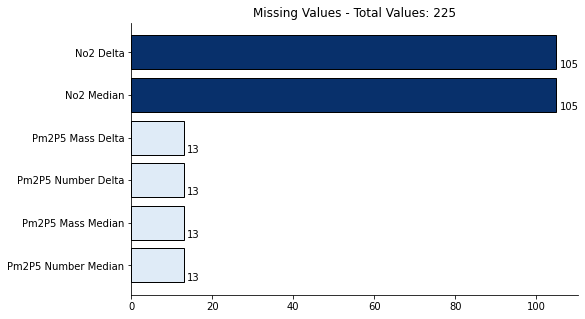

In [52]:
pp.plot_missing_data(features_ieq)

### Self-Report Mood
Now we look at the self-report mood scores

#### Correlated Features
There are most likely correlations with the mood scores that participants report, but these might not be strong enough to justify removing/grouping them in the dataset.

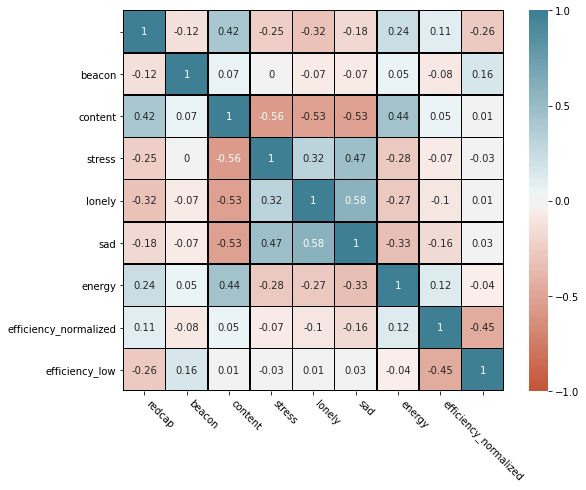

In [53]:
pp.plot_correlation_matrix(features_mood[[column for column in features_mood.columns if column not in targets.columns]],annotate=True)

<div class="alert alert-block alert-info">
    
The most pronounced relationship is between `content` scores and and those of `stress`, `sad`, and `lonely`. Perhaps later analysis can provide a way to combine these "negative" emotional states since there is also an equally strong relationship between `stress` and `sad`.
    
</div>

#### Missing Data
There are some questions that participants opted not to answer for whatever reason. If there are only a few we can justify dropping the row.

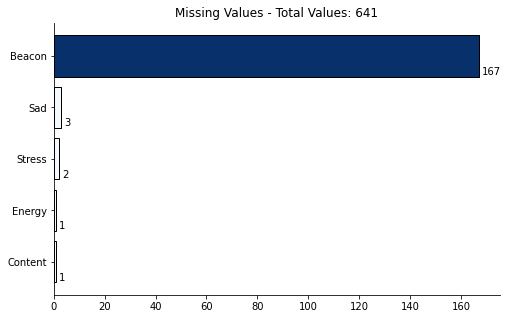

In [54]:
pp.plot_missing_data(features_mood)

A large amount of `beacon` listings are missing from the dataset but that is simply because not all participants received a beacon. The remaining rows are dropped to return a complete dataset.

In [55]:
features_mood.dropna(subset=["content","stress","lonely","sad","energy"],inplace=True)

### Dropping Unecessary Columns
There columns that can be removed because they do not provide any insight:
- ID Columns: `beacon`,`redcap`, `beiwe`, `fitbit`
- Timestamps: `start_time`, `end_time`, `date`, etc.

In [56]:
id_columns = ["beacon","redcap","beiwe","fitbit"]
dt_columns = ["start_time","end_time","date","start_date","end_date"]
datasets = [features_ieq, features_mood, features_srsm, features_activity, labels]
for dataset in datasets:
    dataset = dataset.drop(id_columns+dt_columns,axis="columns",errors="ignore",inplace=True)

## Feature Engineering
We follow along some basic guidelines that are outlined in the [Feature Engineering](https://www.kaggle.com/learn/feature-engineering) course on [Kaggle](https://www.kaggle.com). The general outline is given as follows:

- [Mutual Information](#mutual_information)
- [Clustering](#clustering)
- [Principal Component Analysis](#pca)

Much of this code has been refractured into the `build_features` source code and we import that module below so that we can simplify the code presented in this notebook.

In [57]:
from src.features import build_features
# defining feature engineering object
fe = build_features.feature_engineering()

<a id='mutual_information'></a>

### Mutual Information
Using mutual information, we can get an initial insight into which features relate most closely with the sleep metric targets from Fitbit. This analysis only compares one feature to the target, but there might be more underlying relationships which we can explore further in later sections.

#### Sepcific Case: NO$_2$
The cells below are used to test the functionality of the code in addition to running a specific case for NO$_2$. We run NO$_2$ separately because we have to cut the original dataset down because of all the missing values.

Target: Nrem Percent


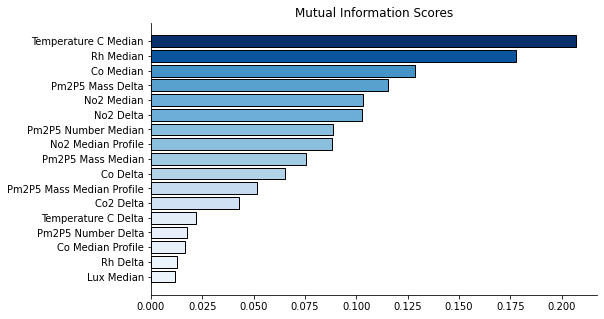

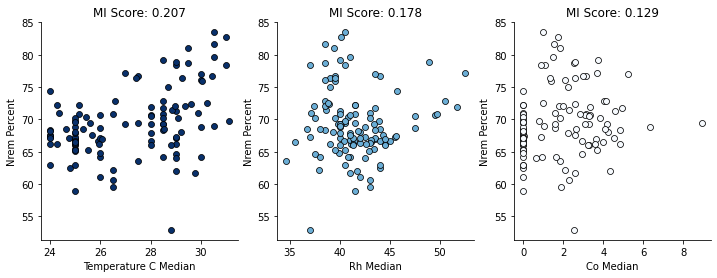

Target: Rem Percent


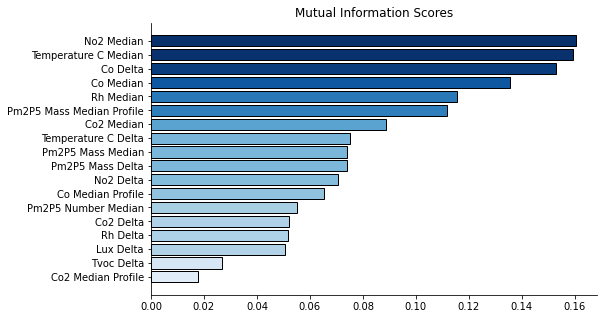

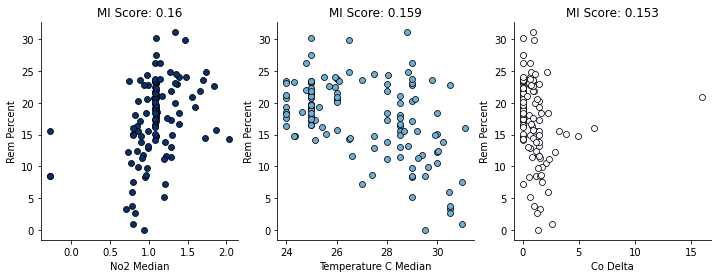

Target: Rem2Nrem Percent


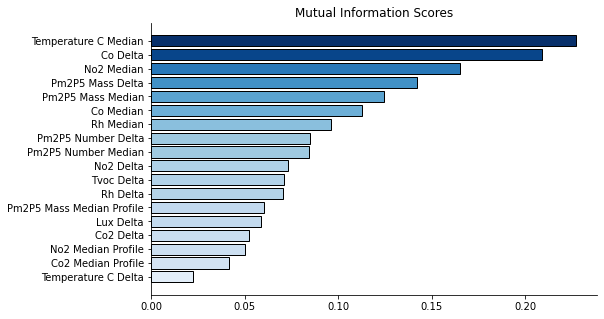

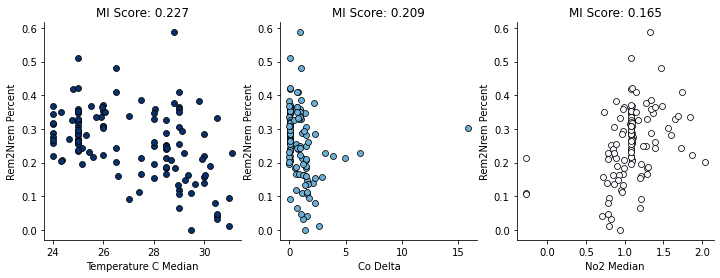

Target: Tst Fb


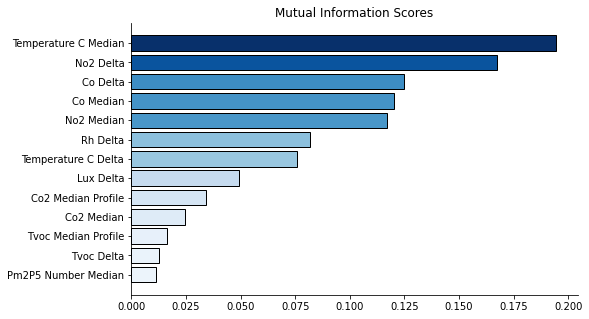

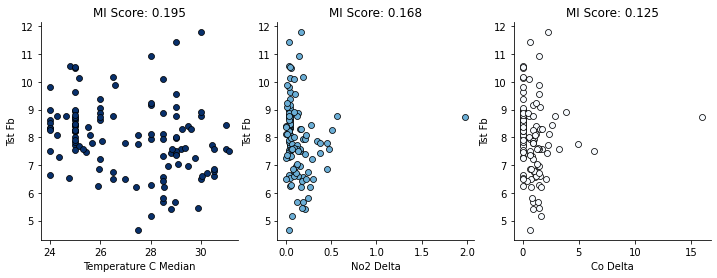

Target: Efficiency


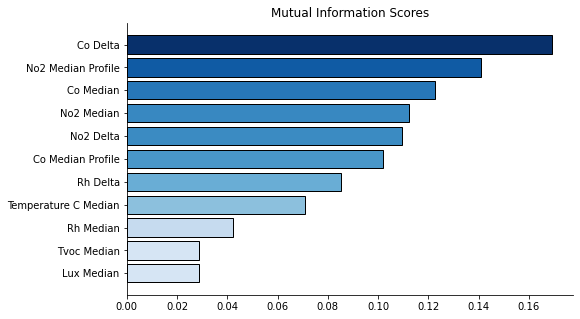

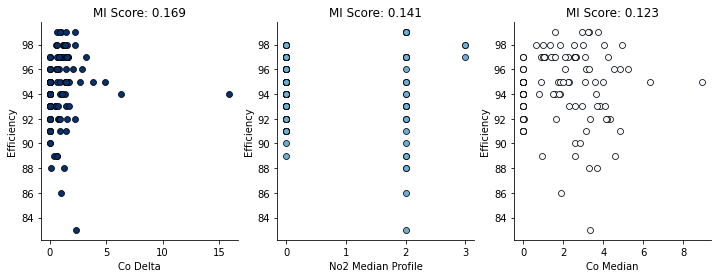

Target: Efficiency Normalized


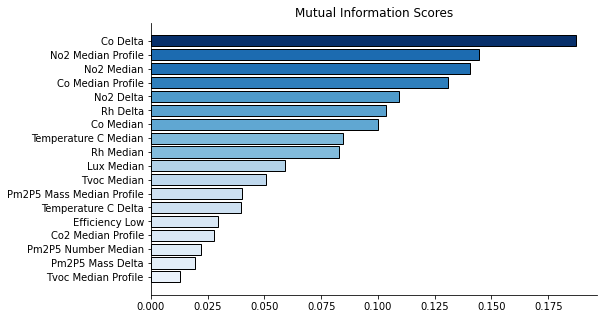

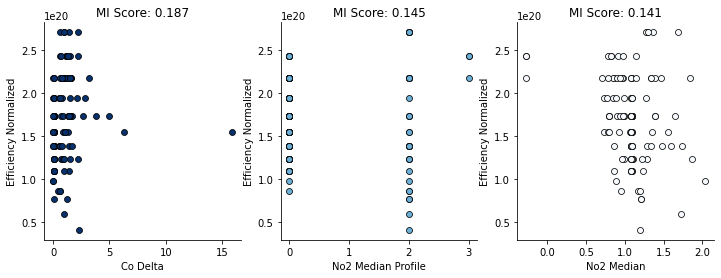

In [136]:
# defining
dataset = features_ieq
features = ["no2_median","no2_delta"]
target_labels = ["nrem_percent","rem_percent","rem2nrem_percent","tst_fb","efficiency","efficiency_normalized"]
vars_to_omit = [var for var in labels.columns if var.endswith("count") or var.endswith("minutes")] + ["light_percent","deep_percent","wake_percent"]
# dropping NaN values
temp = features_ieq.copy()
temp = temp.replace([np.inf, -np.inf], np.nan).dropna(axis="rows")
temp.drop(vars_to_omit,axis="columns",errors="ignore",inplace=True)
fe.check_features_against_targets(temp,target_labels)

#### Application across feature sets
Now that we have working code, we can loop through all the feature sets and pull out the important information.

Dataset: IEQ
Target: Nrem Minutes
	nrem_minutes not in dataframe
Target: Rem Minutes
	rem_minutes not in dataframe
Target: Rem2Nrem Minutes
	rem2nrem_minutes not in dataframe
Target: Tst Fb


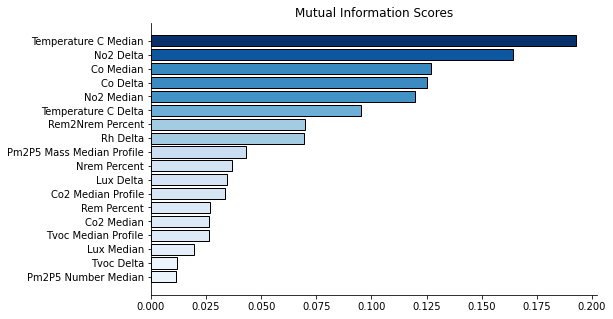

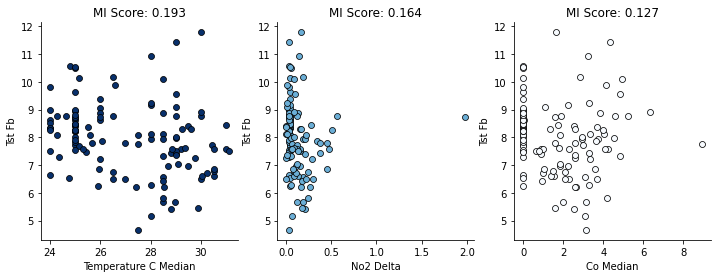

Target: Efficiency


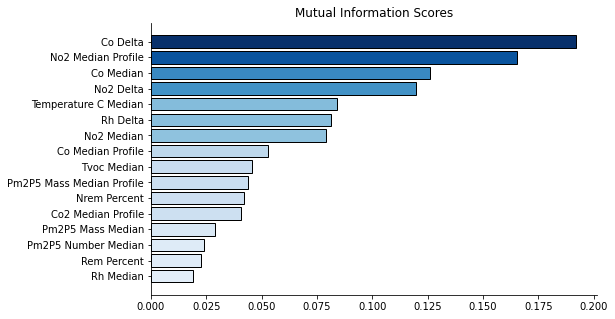

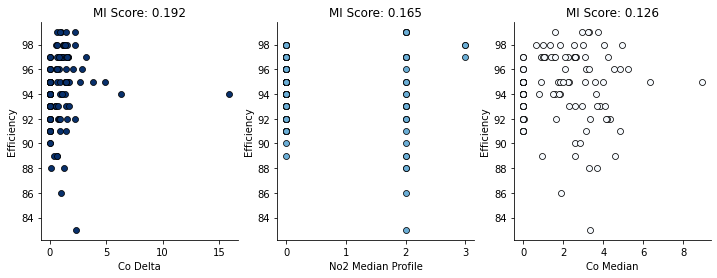

Target: Efficiency Normalized


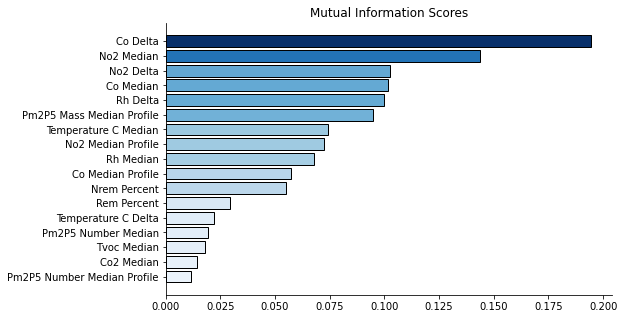

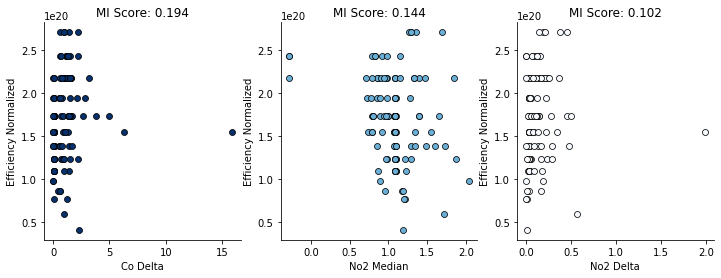

Dataset: Mood
Target: Nrem Minutes
	nrem_minutes not in dataframe
Target: Rem Minutes
	rem_minutes not in dataframe
Target: Rem2Nrem Minutes
	rem2nrem_minutes not in dataframe
Target: Tst Fb


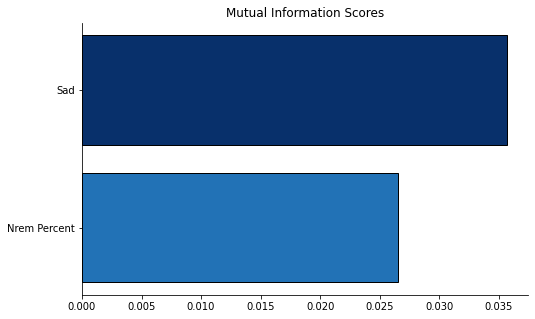

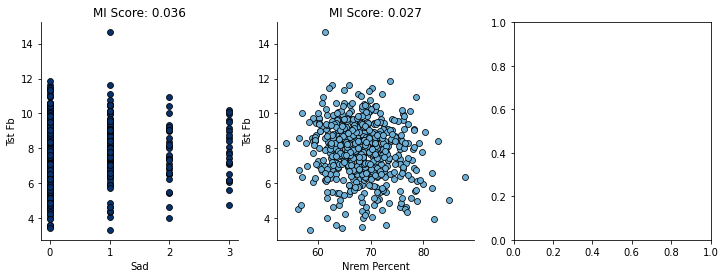

Target: Efficiency


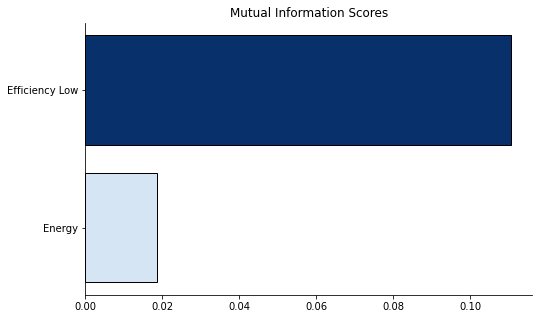

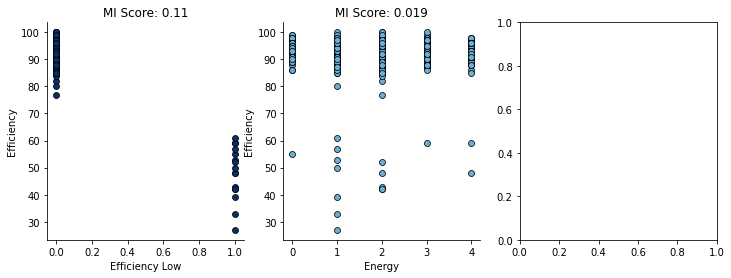

Target: Efficiency Normalized


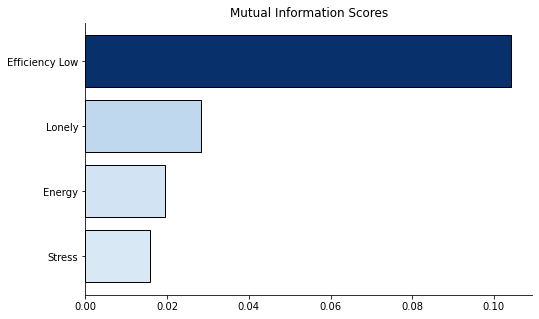

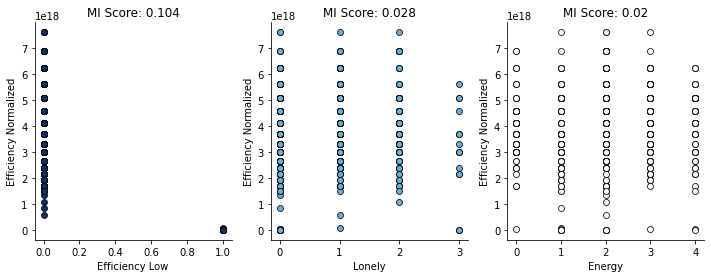

Dataset: Self-Report Sleep
Target: Nrem Minutes
	nrem_minutes not in dataframe
Target: Rem Minutes
	rem_minutes not in dataframe
Target: Rem2Nrem Minutes
	rem2nrem_minutes not in dataframe
Target: Tst Fb


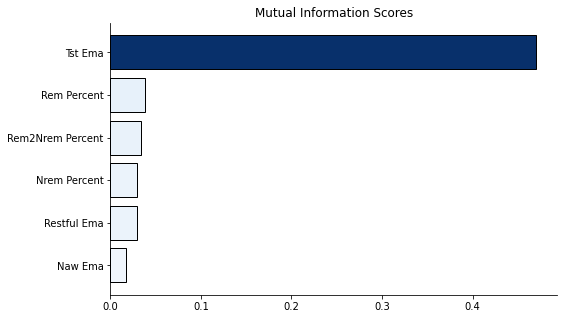

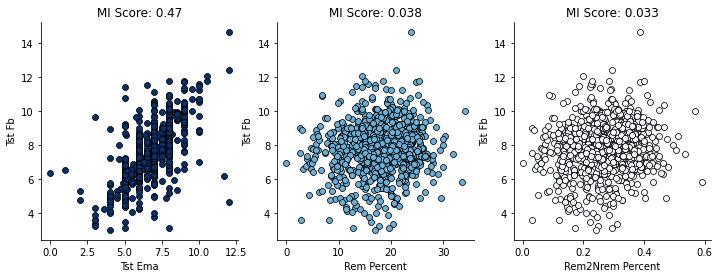

Target: Efficiency


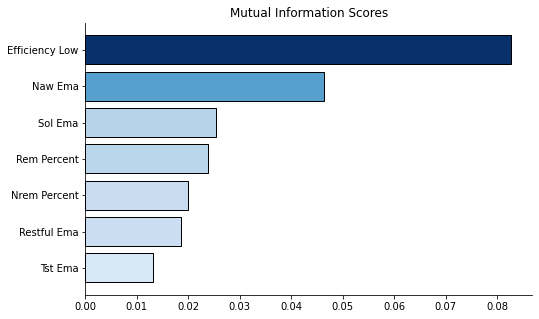

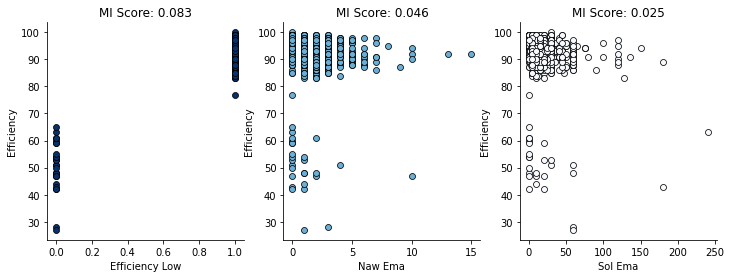

Target: Efficiency Normalized


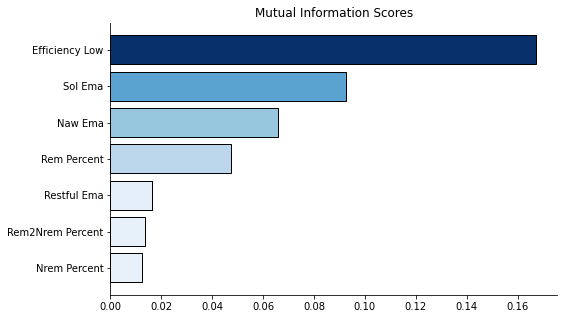

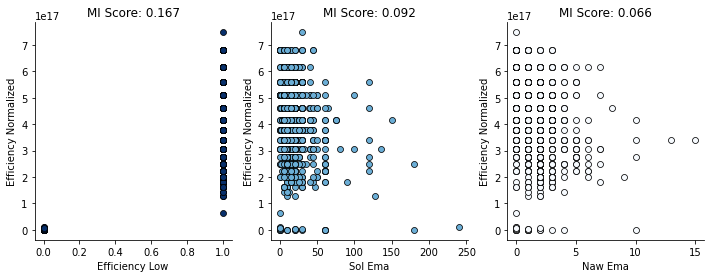

Dataset: Activity
Target: Nrem Minutes
	nrem_minutes not in dataframe
Target: Rem Minutes
	rem_minutes not in dataframe
Target: Rem2Nrem Minutes
	rem2nrem_minutes not in dataframe
Target: Tst Fb


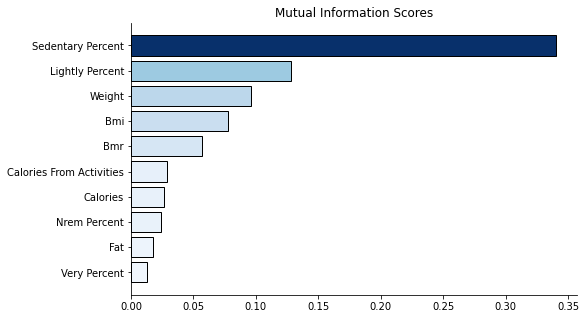

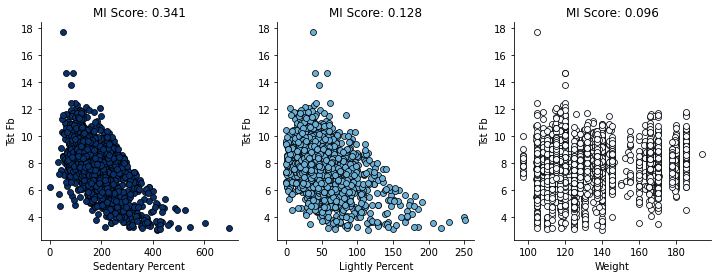

Target: Efficiency


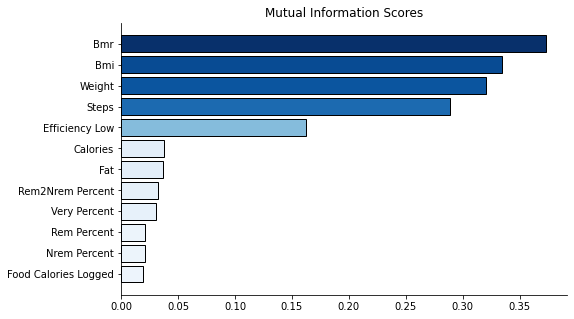

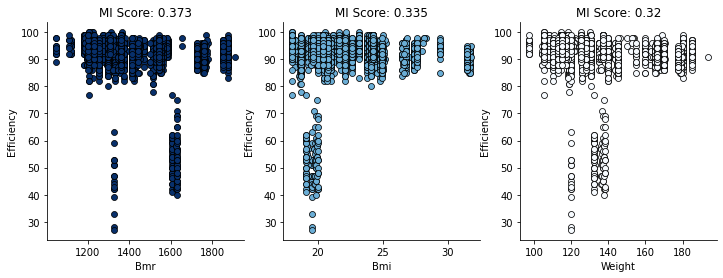

Target: Efficiency Normalized


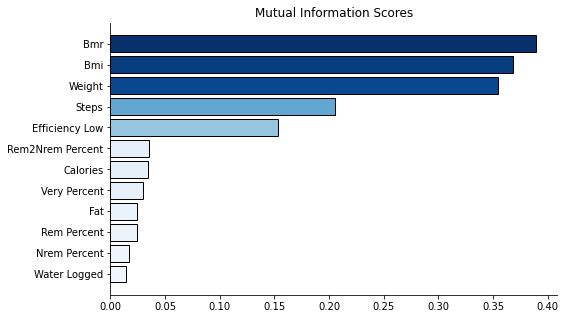

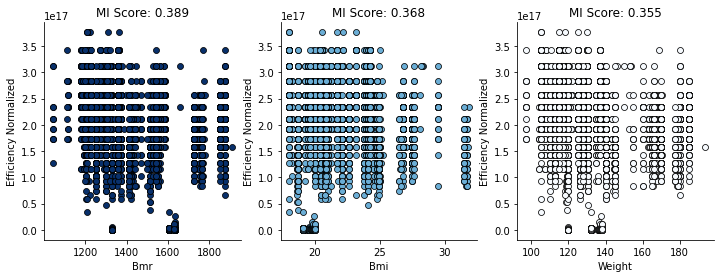

In [137]:
datasets = [features_ieq, features_mood, features_srsm, features_activity]
dataset_names = ["IEQ","Mood","Self-Report Sleep","Activity"]
vars_to_omit = [var for var in labels.columns if var.endswith("count") or var.endswith("minutes")] + ["light_percent","deep_percent","wake_percent"]
target_labels = ["nrem_minutes","rem_minutes","rem2nrem_minutes","tst_fb","efficiency","efficiency_normalized"]
# looping through feature sets and targets
for dataset, name in zip(datasets, dataset_names):
    print(f"Dataset: {name}")
    temp = dataset.copy() # copying
    temp.drop(vars_to_omit,axis="columns",errors="ignore",inplace=True) # dropping unused features
    temp = temp.replace([np.inf, -np.inf], np.nan).dropna(axis="rows") # replacing NaNs and infs
    
    fe.check_features_against_targets(temp,target_labels)

<a id='clustering'></a>

#### Specific Case: Efficiency
Now we can run the same mutual information analysis we ran before, but only consider the higher efficiencies in the larger cluster.

Dataset: IEQ
Target: Efficiency


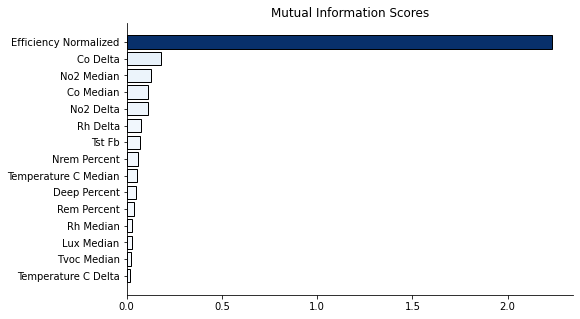

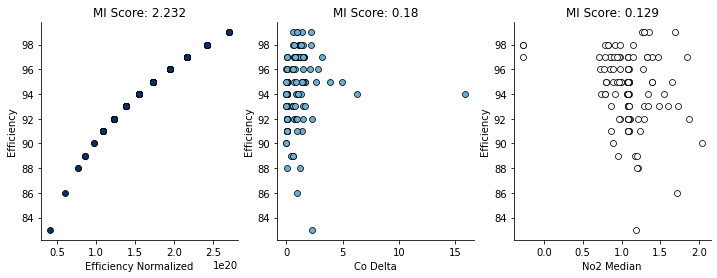

Dataset: Mood
Target: Efficiency


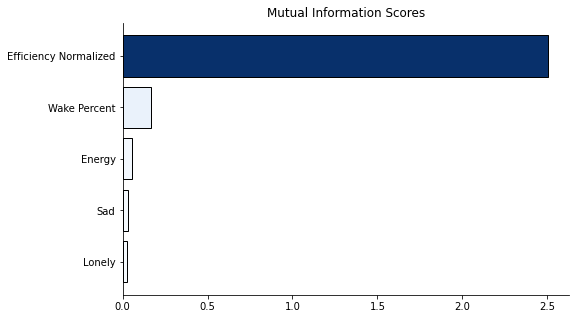

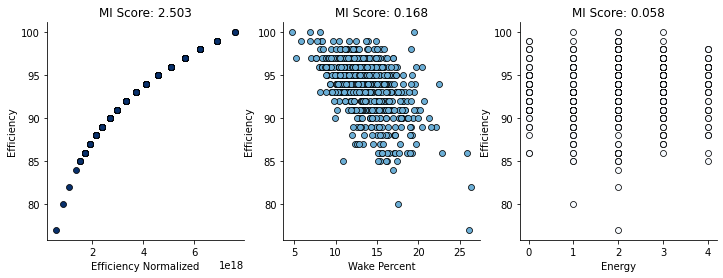

Dataset: Self-Report Sleep
Target: Efficiency


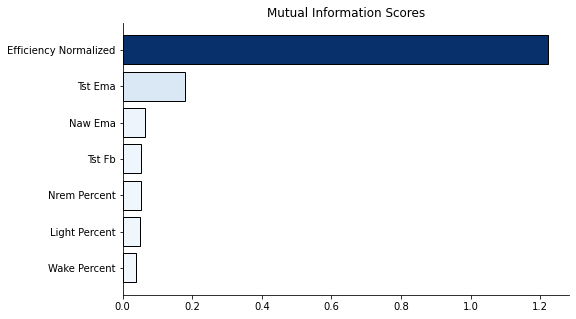

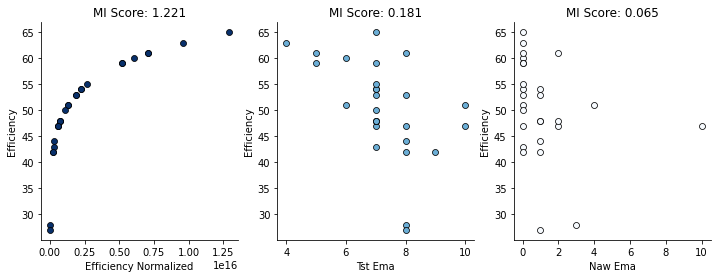

Dataset: Activity
Target: Efficiency


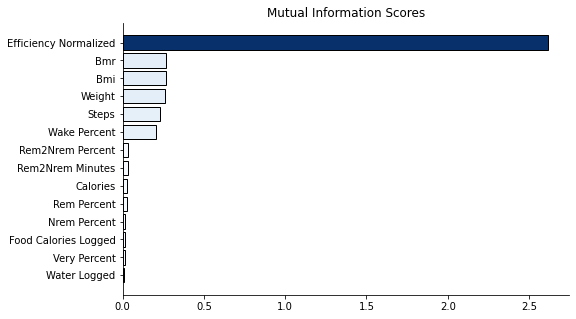

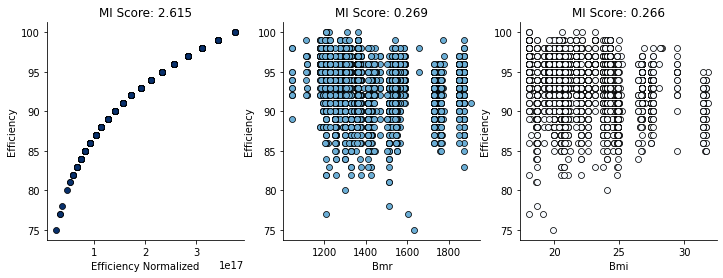

In [64]:
target_labels = ["efficiency"]
for dataset, name in zip(datasets, dataset_names):
    print(f"Dataset: {name}")
    temp = dataset.copy() # copying
    temp.drop(nonfeatures,axis="columns",errors="ignore",inplace=True) # dropping columns that are not features
    temp.drop(vars_to_omit,axis="columns",errors="ignore",inplace=True) # dropping unused features
    temp = temp.replace([np.inf, -np.inf], np.nan).dropna(axis="rows") # replacing NaNs and infs
    temp = temp[temp["efficiency_low"] == 0]
    
    fe.check_features_against_targets(temp,target_labels)

#### Target: Efficiency
The first use of clustering can be to define efficiency based on low and high values. Doing so will help get around the high efficiency values we got when we normalized the data earlier and provide a more natural break. 

#### Feature(s): Pollution Profiles
It is also worthwhile to consider evenings with low, normal, and elevated concentrations of each pollutant. Low and normal concentration profiles are likely to have less of an effect on sleep parameters while elevated concentrations are what we are _hoping_ affects sleep quality. We will base the clusters off of the **mean** concentration experienced during a given evening.

In [66]:
datasets = [features_ieq]
for dataset in datasets:
    summary_stat = "median"
    for pollutant in ["pm2p5_mass","pm2p5_number","co","co2","no2","tvoc"]:
        dataset[f"{pollutant}_{summary_stat}"].fillna(-100,inplace=True) # temporarily filling nans to run kmeans
        if -100 in dataset[f"{pollutant}_{summary_stat}"].unique():
            kmeans = KMeans(n_clusters=4, n_init=10, random_state=0)
        else:
            kmeans = KMeans(n_clusters=3, n_init=10, random_state=0)
            
        dataset[f"{pollutant}_{summary_stat}_profile"] = kmeans.fit_predict(np.array(dataset[f"{pollutant}_{summary_stat}"]).reshape(-1, 1))
    dataset.replace(-100,np.nan,inplace=True) # replacing artificial values with nan

Now we can see if clustering the pollution profiles created any noticeable differences in sleep metrics.

pm2p5 mass


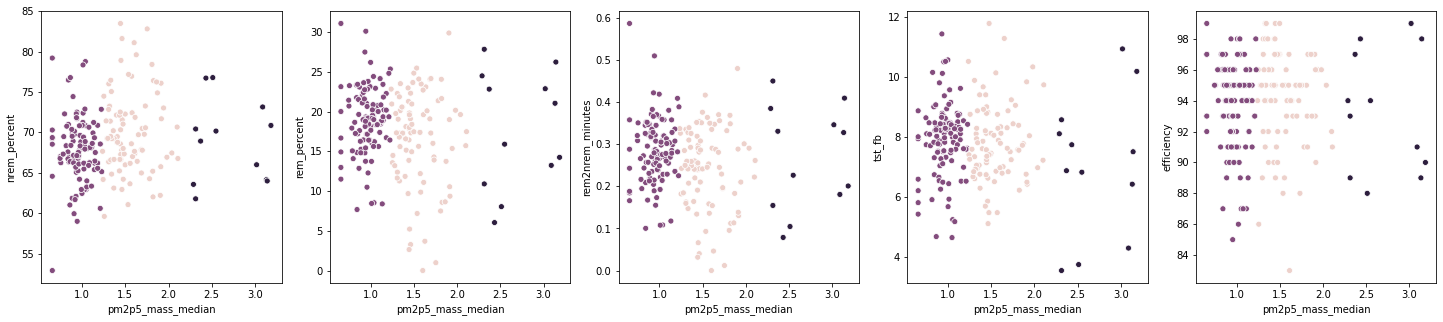

pm2p5 number


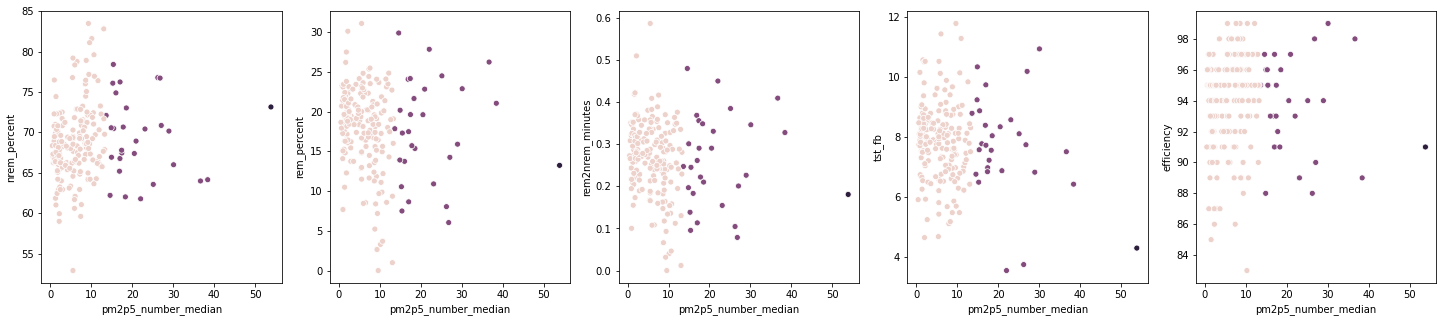

co


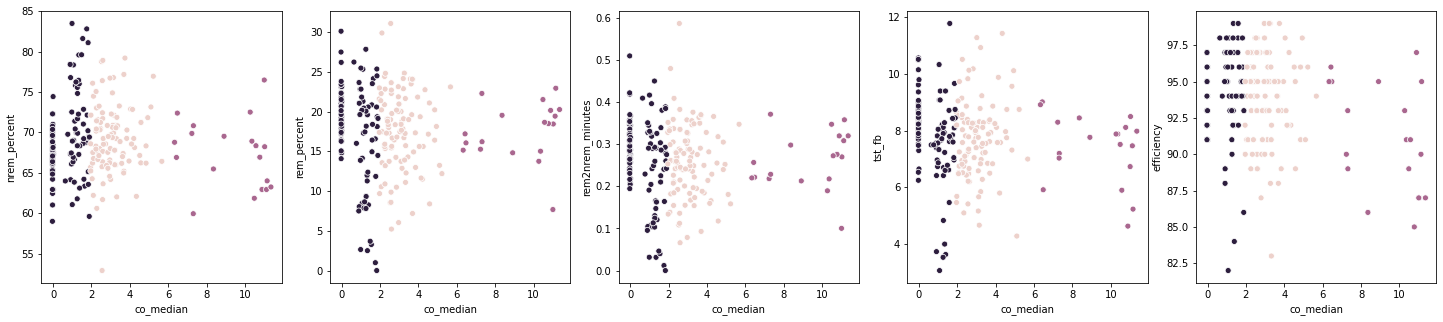

co2


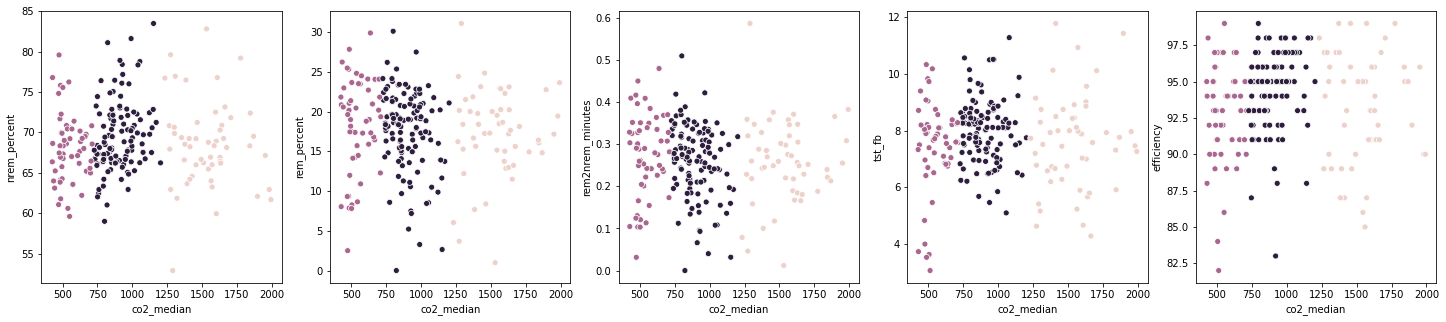

no2


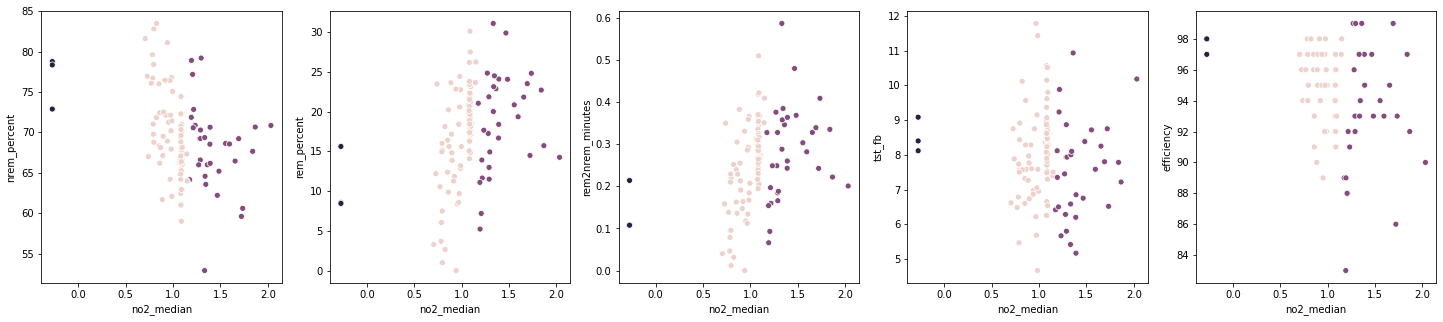

tvoc


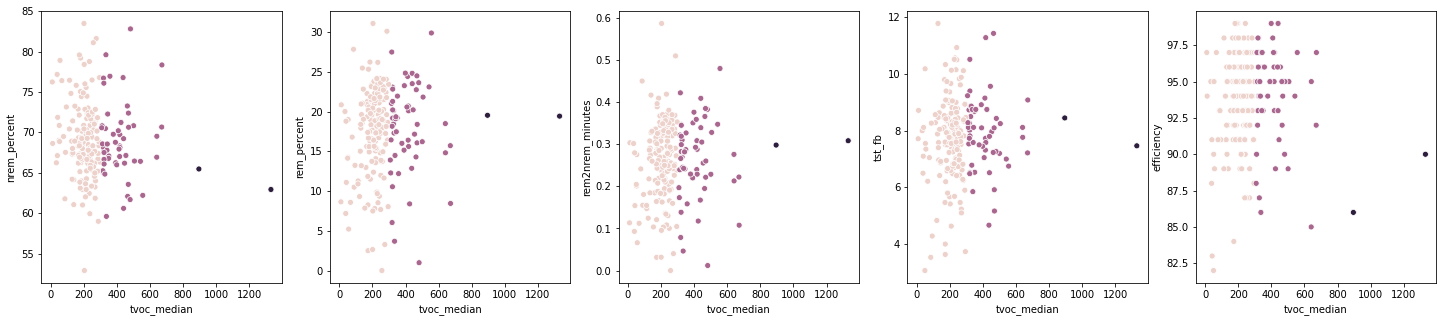

In [68]:
target_labels = ["nrem_percent","rem_percent","rem2nrem_minutes","tst_fb","efficiency"]
temp = features_ieq.copy()
temp = temp[temp["efficiency_low"] == 0]
for pollutant in ["pm2p5_mass","pm2p5_number","co","co2","no2","tvoc"]:
    print(pollutant.replace("_"," "))
    fig, axes = plt.subplots(1,len(target_labels),figsize=(5*len(target_labels),5))
    for target_label, ax in zip(target_labels,axes.flat):
        df_to_plot = temp.dropna(subset=[f"{pollutant}_{summary_stat}"],axis=0)
        sns.scatterplot(x=f"{pollutant}_{summary_stat}",y=target_label,hue=f"{pollutant}_{summary_stat}_profile",data=temp,legend=False,ax=ax)
        
    plt.show()
    plt.close()

<div class="alert alert-block alert-info">
    
There do not seem to be any strong correlations between sleep **mean** pollutant concentration and any of the Fitbit-measured sleep metrics. 
    
</div>

<a id="pca"></a>

### Principal Component Analysis
The following cells use Principal Component Analysis (PCA) to help identify relationships between features, create features in the datasets, and show any outlying data points.

In [69]:
from sklearn.decomposition import PCA

#### Idenfitying Relationships
We start using PCA by analyzing relationships between features. We can look at each of the feature sets to see which variables have some sort of correlation.

Below we define a function to grab the features we are interested in and scale them for a better analysis.

In [75]:
def features_for_pca(df, feature_labels, scale=True):
    """
    Collects features from the original dataframe and scales them
    
    Inputs:
    - df: dataframe with features
    - features_labels: list of strings specifying the columns to pull from df
    - scale: whether or not to scale the values
    
    Returns a dataframe with scaled features
    """
    X = df.copy()
    X = X.loc[:, feature_labels]
    if scale:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
        
    return X

We will also create a function that performs the PCA for us and returns a nicely formatted dataframe.

In [81]:
def run_pca(X):
    """
    Take a feature set, performs PCA, and returns the formatted results
    
    Returns a dataframe of the formatted results from PCA
    """
    pca = PCA()
    X_pca = pca.fit_transform(X)
    
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return loadings, pca

And lastly two functions to help visualize the relationships by.

In [114]:
def visualize_pca(loadings, pca):
    """
    Plots a bar chart, cumulative plot, and heatmap of the pca loadings 
    
    Returns void
    """
    fig, axes = plt.subplots(1,3,figsize=(12,4))
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    my_cmap = plt.get_cmap("Blues")
    rescale = lambda y: y / np.max(y)
    evr = pca.explained_variance_ratio_
    axes[0].bar(grid, evr, color=my_cmap(rescale(evr)))
    axes[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axes[1].plot(np.r_[0, grid], np.r_[0, cv], "o-", linewidth=2,color="black")
    axes[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    for ax in axes.flat[:2]:
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
        
    sns.heatmap(loadings,vmin=-1,vmax=1,annot=True,square=True,
                linecolor="black",linewidth=1,cmap="coolwarm_r",
                yticklabels=[var.replace("_"," ").title() for var in loadings.index],cbar_kws={"ticks":[-1,-0.5,0,0.5,1]},ax=axes[2])
    plt.yticks(rotation=0)
    
    plt.show()
    plt.close()

##### Self-Report Mood
Mood is only reported on a four-point scale so perhaps PCA is not applicable in this case, but we can still check.

In [105]:
features_mood.columns[22:]

Index(['efficiency_low'], dtype='object')

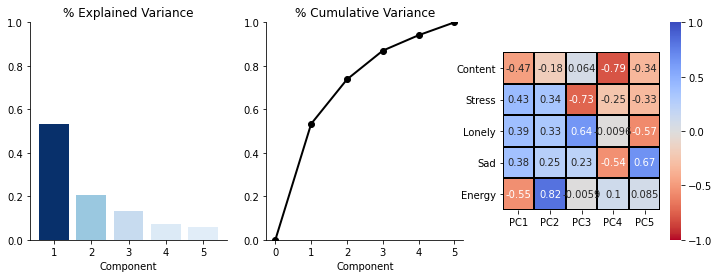

In [106]:
# getting data
X = features_for_pca(features_mood, feature_labels=['content', 'stress', 'lonely', 'sad', 'energy'], scale=False) # No need to scale since our values are all on the same scale already
# running pca
loadings, pca = run_pca(X)
# displaying results
visualize_pca(loadings,pca)

##### Self-Report Sleep

In [107]:
features_srsm.columns[22:]

Index([], dtype='object')

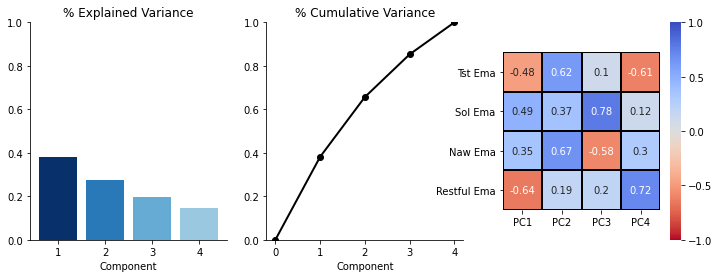

In [108]:
# getting data
X = features_for_pca(features_srsm, feature_labels=['tst_ema', 'sol_ema', 'naw_ema', 'restful_ema'], scale=True)
# running pca
loadings, pca = run_pca(X)
# displaying results
visualize_pca(loadings,pca)

##### Fitbit Activity

In [109]:
features_activity.columns[22:]

Index(['rem_percent', 'wake_percent', 'nrem_percent', 'sedentary_percent',
       'lightly_percent', 'fairly_percent', 'very_percent', 'rem2nrem_percent',
       'efficiency_normalized', 'efficiency_low'],
      dtype='object')

In [112]:
# getting data
X = features_for_pca(features_activity, feature_labels=['calories', 'steps', 'distance', 'sedentary_minutes', 'lightly_active_minutes','fairly_active_minutes', 'very_active_minutes'], scale=True)
# running pca
loadings, pca = run_pca(X)
# displaying results
visualize_pca(loadings,pca)

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'